# HW4 - Q6: Exploring Inductive Bias of Convolutional Neural Networks and Systematic Experimentation in Machine Learning

In this homework, we will study 1) what is inductive bias and how it affects the learning process, and 2) how to conduct systematic experiments in machine learning. We will compare convolutional neural networks (CNNs) and multi-layer perceptrons (MLPs) extensively as an example to study these two topics.

## 1. Inductive Bias

What is inductive bias? It is the assumption that the learning algorithm makes about the problem domain. Suppose that we build a machine learning system. We want to leverage the specific knowledge about the problem domain to make the learning process **more efficient** and the system **generalize much better** with fewer parameters. Let's be more precise. What do exactly **more efficient** and **generalize much better** mean? The learning process is more efficient 1) if we can learn the model with fewer parameters, 2) if we can learn the model with fewer data, and 3) if we can learn the model with fewer iterations. And the system generalizes much better if the model can generalize to the unseen data well.

We have already observed the power of inductive bias. We know that CNN generalizes better than MLP even with the same number of parameters. We partially concluded that is because CNN has the inductive bias that the model is translation invariant. We will study the inductive bias of CNN in more detail in this homework.

In this homework, we will use the edge detection task as an example to study the inductive bias of CNN. We will compare CNN and MLP extensively. And we will see when CNN can fail.

## 2. Systematic Experimentation in Machine Learning

How can we prove our hypothesis that CNN has the inductive bias that the model is translation invariant? We conduct extensive experiments in machine learning research (and other fields) to prove our hypothesis. In this context, systematic experimentation refers to running a series of experiments to prove our hypothesis. In this homework, we will study how to conduct systematic experimentation in machine learning.

Let's take a step back and think about 1) what our hypothesis is and 2) what experiments are needed to conduct to prove our hypothesis. The first question is easy. The hypothesis is that CNN has the inductive biases of locality and translational invariance. It is not enough to show that CNN performs better than MLP with the same number of parameters. Then, how do we design the experiments to prove our hypothesis? In this homework, we will design the experiments, conduct the experiments, analyze the results, and draw a conclusion.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToPILImage

from PIL import Image
from scipy.ndimage.interpolation import rotate
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from copy import deepcopy
from torch.utils.data import DataLoader

/tmp/ipython-input-3989156832.py:15: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate


### Helper functions

The following code cell defines function and classes that will be used in the succeeding codes. Feel free to check it if you are not sure about details.

In [2]:
class EdgeDetectionDataset(Dataset):
    def __init__(self, domain_config, mode="train", transform=None) -> None:
        """
        Args:
            domain_config (dict): Domain configuration
                data_per_class (int): Number of data per class
                num_classes (int): Number of classes
                class_type (list): List of class types
                spatial_resolution (int): length of height and width of the image
                max_edge_width (int): Maximum edge width
                max_edge_intensity (float): Maximum edge intensity
                min_edge_intensity (float): Minimum edge intensity
                max_background_intensity (float): Maximum background intensity
                min_background_intensity (float): Minimum background intensity
                possible_edge_location_ratio (float): Confine the possible edge location to a ratio of the spatial resolution
                num_horizontal_edge (int): Number of horizontal edges
                num_vertical_edge (int): Number of vertical edges
                use_permutation (bool): Whether to apply random permutation on the image
            mode (str): Mode of the dataset (train, val, test)
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_per_class = domain_config.get("data_per_class", 1000)
        self.num_classes = domain_config.get("num_classes", 3)
        self.class_type = domain_config.get(
            "class_type", ["horizontal", "vertical", "none"]
        )
        self.spatial_resolution = domain_config.get("spatial_resolution", 28)
        self.min_edge_width = domain_config.get("min_edge_width", 1)
        self.max_edge_width = domain_config.get("max_edge_width", 4)
        self.max_edge_intensity = domain_config.get("max_edge_intensity", 1)
        self.min_edge_intensity = domain_config.get("min_edge_intensity", 0.25)
        self.max_background_intensity = domain_config.get(
            "max_background_intensity", 0.2
        )
        self.min_background_intensity = domain_config.get("min_background_intensity", 0)
        self.possible_edge_location_ratio = domain_config.get(
            "possible_edge_location_ratio", 1.0
        )
        self.num_horizontal_edge = domain_config.get("num_horizontal_edge", 1)
        self.num_vertical_edge = domain_config.get("num_vertical_edge", 1)
        self.num_diagonal_edge = domain_config.get("num_diagonal_edge", 1)
        self.use_permutation = domain_config.get("use_permutation", False)
        self.permutater = domain_config.get("permutater", None)
        self.unpermutater = domain_config.get("unpermutater", None)

        if self.possible_edge_location_ratio < 1.0:
            self.train_val_domain_shift = True
        else:
            self.train_val_domain_shift = False

        self.possible_edge_location = int(
            self.possible_edge_location_ratio * self.spatial_resolution
        )
        self.mode = mode

        assert self.num_classes == len(
            self.class_type
        ), "Number of classes must match the number of class types"

        assert self.mode in (
            "train",
            "valid",
            "test",
        ), "Mode must be either train, valid, or test"

        self.X = None
        self.y = None

        if self.use_permutation:
            assert self.permutater is not None, "permutater must be provided"
            assert self.unpermutater is not None, "Unpermutater must be provided"

        self._generate_dataset()

        self.transform = transform

    def __len__(self):
        """
        Returns:
            int: Length of the dataset
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample
        Returns:
            tuple: (sample, label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.X[idx]
        label = self.y[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

    def get_permutater(self):
        """
        Returns:
            np.ndarray: Permutation matrix
        """
        return self.permutater

    def get_unpermutater(self):
        """
        Returns:
            np.ndarray: Unpermutation matrix
        """
        return self.unpermutater

    def _permute_pixels(self, X):
        """
        Args:
            X (np.ndarray): Image
        Returns:
            np.ndarray: Permuted image
        """
        assert X.shape[0] == self.data_per_class, "Invalid image shape"
        assert len(X.shape) == 4, "Invalid image shape"

        n, h, w, c = X.shape

        X = X.reshape(n, h * w, c)
        X = X[:, self.permutater, :]
        X = X.reshape(n, h, w, c)

        return X

    def _edge_intensity(self, edge_type="horizontal"):
        """
        Args:
            edge_type (str): Type of edge (horizontal, vertical, both, diagonal)
        Returns:
            np.ndarray: Edge intensity
        """
        if edge_type == "horizontal":
            num_edge = self.num_horizontal_edge
        elif edge_type == "vertical":
            num_edge = self.num_vertical_edge
        elif edge_type == "diagonal":
            num_edge = self.num_diagonal_edge
        elif edge_type == "both":
            num_edge = self.num_horizontal_edge + self.num_vertical_edge
        else:
            raise ValueError("Invalid edge type")

        return np.random.uniform(
            self.min_edge_intensity,
            self.max_edge_intensity,
            size=(self.data_per_class, num_edge),
        )

    def _edge_location(self, edge_type="horizontal"):
        """
        Args:
            edge_type (str): Type of edge (horizontal, vertical, both, diagonal)
        Returns:
            np.ndarray: Edge location
        """
        max_edge_width = self.max_edge_width + 1
        if edge_type == "horizontal":
            num_edge = self.num_horizontal_edge
        elif edge_type == "vertical":
            num_edge = self.num_vertical_edge
        elif edge_type == "diagonal":
            num_edge = self.num_diagonal_edge
            max_edge_width = int(self.max_edge_width / np.sqrt(2))
        elif edge_type == "both":
            num_edge = self.num_horizontal_edge + self.num_vertical_edge
        else:
            raise ValueError("Invalid edge type")

        edge_width = np.random.randint(
            self.min_edge_width, max_edge_width, size=(self.data_per_class, num_edge)
        )

        if self.mode == "train" and self.train_val_domain_shift:
            edge_location_start_idx = np.random.randint(
                0,
                self.possible_edge_location - edge_width,
                size=(self.data_per_class, num_edge),
            )
            edge_location_end_idx = np.clip(
                edge_location_start_idx + edge_width,
                0,
                self.possible_edge_location-1,
            )

        elif self.mode == "valid" and self.train_val_domain_shift:
            edge_location_start_idx = np.random.randint(
                self.possible_edge_location,
                self.spatial_resolution - edge_width,
                size=(self.data_per_class, num_edge),
            )
            edge_location_end_idx = np.clip(
                edge_location_start_idx + edge_width,
                self.possible_edge_location,
                self.spatial_resolution-1,
            )

        else:
            edge_location_start_idx = np.random.randint(
                0,
                self.spatial_resolution - edge_width,
                size=(self.data_per_class, num_edge),
            )
            edge_location_end_idx = np.clip(
                edge_location_start_idx + edge_width,
                0,
                self.spatial_resolution-1,
            )

        return edge_location_start_idx, edge_location_end_idx

    def _generate_hoizontal_edge_images(self):
        """
        Generate horizontal edge images
        Returns:
            np.ndarray: Generated horizontal edge images
        """
        assert (
            self.num_horizontal_edge > 0
        ), "Number of horizontal edge must be greater than 0"

        X = self._generate_background_images()

        edge_location_start_idx, edge_location_end_idx = self._edge_location(
            edge_type="horizontal"
        )
        edge_intensity = self._edge_intensity()

        for i in range(self.data_per_class):
            for j in range(self.num_horizontal_edge):
                X[
                    i, edge_location_start_idx[i, j] : edge_location_end_idx[i, j], :, :
                ] = edge_intensity[i, j]

        return X

    def _generate_vertical_edge_images(self):
        """
        Generate vertical edge images
        Returns:
            np.ndarray: Generated vertical edge images
        """
        assert (
            self.num_vertical_edge > 0
        ), "Number of vertical edge must be greater than 0"

        X = self._generate_background_images()

        edge_location_start_idx, edge_location_end_idx = self._edge_location(
            edge_type="vertical"
        )
        edge_intensity = self._edge_intensity()

        for i in range(self.data_per_class):
            for j in range(self.num_vertical_edge):
                X[
                    i,
                    :,
                    edge_location_start_idx[i, j] : edge_location_end_idx[i, j],
                    :,
                ] = edge_intensity[i, j]

        return X

    def _generate_both_edge_images(self):
        """
        Generate horizontal/vertical edge images
        Returns:
            np.ndarray: Generated horizontal/vertical edge images
        """
        assert (
            self.num_horizontal_edge > 0
        ), "Number of horizontal edge must be greater than 0"
        assert (
            self.num_vertical_edge > 0
        ), "Number of vertical edge must be greater than 0"

        X = self._generate_background_images()

        edge_location_start_idx, edge_location_end_idx = self._edge_location(
            edge_type="both"
        )
        edge_intensity = self._edge_intensity(edge_type="both")

        for i in range(self.data_per_class):
            for j in range(self.num_horizontal_edge):
                X[
                    i,
                    edge_location_start_idx[i, j] : edge_location_end_idx[i, j],
                    :,
                    :,
                ] = edge_intensity[i, j]
            for j in range(self.num_vertical_edge):
                X[
                    i,
                    :,
                    edge_location_start_idx[i, j] : edge_location_end_idx[i, j],
                ] = edge_intensity[i, self.num_horizontal_edge + j]

        return X

    def _generate_diagonal_edge_images(self):
        """
        Generate diagonal edge images by rotating images
        Returns:
            np.ndarray: Generated diagonal edge images
        """
        assert (
            self.num_diagonal_edge > 0
        ), "Number of diagonal edge must be greater than 0"

        X = self._generate_background_images()
        background_intensity = np.mean(X, axis=(1, 2, 3))

        edge_location_start_idx, edge_location_end_idx = self._edge_location(
            edge_type="diagonal"
        )
        edge_intensity = self._edge_intensity(edge_type="diagonal")

        random_angle = np.random.choice(
            [30, 45, 120, 135], size=(self.data_per_class, self.num_diagonal_edge)
        )

        for i in range(self.data_per_class):
            for j in range(self.num_diagonal_edge):
                if i % 2 == 0:  # horizontal
                    X[
                        i,
                        edge_location_start_idx[i, j] : edge_location_end_idx[i, j],
                        :,
                        :,
                    ] = edge_intensity[i, j]
                else:  # vertical
                    X[
                        i,
                        :,
                        edge_location_start_idx[i, j] : edge_location_end_idx[i, j],
                    ] = edge_intensity[i, j]
                X[i] = rotate(
                    X[i],
                    random_angle[i, j],
                    reshape=False,
                    mode="constant",
                    cval=background_intensity[i],
                )
        return X

    def _generate_background_images(self):
        """
        Generate background images
        Returns:
            np.ndarray: Generated background images
        """
        X = np.ones(
            (self.data_per_class, self.spatial_resolution, self.spatial_resolution, 1),
        )  # NHWC format
        X *= np.random.uniform(
            self.min_background_intensity,
            self.max_background_intensity,
            size=(self.data_per_class, 1, 1, 1),
        )
        return X

    def get_image_statistics(self):
        """
        Get image statistics
        Returns:
            tuple: (mean, std)
            mean (float): Mean of the images
            std (float): Standard deviation of the images
        """
        return self._mean, self._std

    def _generate_dataset(self):
        """
        Generate dataset
        Returns:
            tuple: (X, y)
            X (list of PIL Image): Generated images
            y (np.ndarray): Generated labels
        """
        num_data = self.data_per_class * self.num_classes
        self.X = np.zeros(
            (num_data, self.spatial_resolution, self.spatial_resolution, 1)
        )
        self.y = np.zeros((num_data,), dtype=np.int64)
        for i in range(self.num_classes):
            class_type = self.class_type[i]
            if class_type == "horizontal":
                X = self._generate_hoizontal_edge_images()
            elif class_type == "vertical":
                X = self._generate_vertical_edge_images()
            elif class_type == "both":
                X = self._generate_both_edge_images()
            elif class_type == "diagonal":
                X = self._generate_diagonal_edge_images()
            elif class_type == "none":
                X = self._generate_background_images()
            else:
                raise ValueError("Invalid class type")

            assert X.shape == (
                self.data_per_class,
                self.spatial_resolution,
                self.spatial_resolution,
                1,
            )  # NHWC format

            # permute pixels
            if self.use_permutation:
                X = self._permute_pixels(X)

            self.X[i * self.data_per_class : (i + 1) * self.data_per_class] = X
            self.y[i * self.data_per_class : (i + 1) * self.data_per_class] = i

        # Compute mean and std
        self._mean = np.mean(self.X)
        self._std = np.std(self.X)

        # np.float32 -> np.uint8
        self.X = (self.X * 255).astype(np.uint8)

        # Convert ndarray to PIL Image
        self.X = [T.functional.to_pil_image(x) for x in self.X]


def count_parameters(model, only_trainable=False):
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

def freeze_conv_layer(model):
    for name, param in model.named_parameters():
        if name.startswith('conv'):
            param.requires_grad = False

def init_conv_kernel_with_edge_detector(model):
    # Get kernel size
    kernel_size = model.conv1.kernel_size[0]

    # number of filters should be 3
    num_filters = model.conv1.out_channels
    assert num_filters == 3, "Number of filters should be 3"

    if kernel_size == 2:
        # 2 x 2 edge detector
        horizontal_edge_detector = torch.tensor([[1, 1], [-1, -1]], dtype=torch.float32)
        vertical_edge_detector = torch.tensor([[1, -1], [1, -1]], dtype=torch.float32)
        none_edge_detector = torch.tensor([[0, 0], [0, 0]], dtype=torch.float32)
    elif kernel_size == 7:
        # 7 x 7 edge detector
        horizontal_edge_detector = torch.tensor([
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 1],
            [-1, -1, -1, -1, -1, -1, -1],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0]], dtype=torch.float32)
        vertical_edge_detector = horizontal_edge_detector.T
        none_edge_detector = model.conv1.weight.data[0, 0] # torch.zeros((7, 7), dtype=torch.float32)
    else:
        horizontal_edge_detector = torch.from_numpy(custom_sobel((kernel_size, kernel_size), 0))
        vertical_edge_detector = torch.from_numpy(custom_sobel((kernel_size, kernel_size), 1))
        none_edge_detector = torch.from_numpy(np.zeros((kernel_size, kernel_size)))

    edge_detector = torch.stack([horizontal_edge_detector, vertical_edge_detector, none_edge_detector])
    model.conv1.weight.data = edge_detector.view(model.num_filter, 1, model.kernel_size, model.kernel_size)
    model.conv2.weight.data = torch.cat([model.conv1.weight.data, model.conv1.weight.data, model.conv1.weight.data], dim=1)

    # type casting
    model.conv1.weight.data = model.conv1.weight.data.type(torch.FloatTensor)
    model.conv2.weight.data = model.conv2.weight.data.type(torch.FloatTensor)

    # bias
    model.conv1.bias.data = torch.tensor([0, 0, 0], dtype=torch.float32)
    model.conv2.bias.data = torch.tensor([0, 0, 0], dtype=torch.float32)

def custom_sobel(shape, axis):
    """
    shape must be odd: eg. (5,5)
    axis is the direction, with 0 to positive x and 1 to positive y
    """
    k = np.zeros(shape, dtype=np.float32)
    p = [(j,i) for j in range(shape[0])
           for i in range(shape[1])
           if not (i == (shape[1] -1)/2. and j == (shape[0] -1)/2.)]

    for j, i in p:
        j_ = int(j - (shape[0] -1)/2.)
        i_ = int(i - (shape[1] -1)/2.)
        k[j,i] = (i_ if axis==0 else j_)/float(i_*i_ + j_*j_)
    return k


def set_seed(seed):
    """
    Set the seed for all random number generators.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def train_one_epoch(
    model,
    optimizer,
    criterion,
    train_loader,
    device,
    epoch,
    log_interval=100,
    verbose=True,
):
    model.train()
    # return the average loss and accuracy
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(
            dim=1, keepdim=True
        )
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0 and verbose:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / len(train_loader.dataset) * 100.

    return train_loss, train_accuracy

def _generate_confusion_matrix(pred_list, target_list):
    pred_list = torch.cat(pred_list)
    target_list = torch.cat(target_list)

    assert pred_list.shape[0] == target_list.shape[0], "predictions and targets should have the same length"

    matrix_size = max(max(pred_list), max(target_list)) + 1
    confusion_matrix = torch.zeros(matrix_size, matrix_size)

    for t, p in zip(target_list.view(-1), pred_list.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix.cpu().numpy()

def evaluate(model, criterion, valid_loader, device, verbose=True):
    model.eval()
    valid_loss = 0
    correct = 0

    pred_list, target_list = [], []
    confusion_matrix = torch.zeros(4, 4)

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            valid_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            pred_list.append(pred)
            target_list.append(target)

    confusion_matrix = _generate_confusion_matrix(pred_list, target_list)

    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100.0 * correct / len(valid_loader.dataset)

    if verbose:
        print(
            "Validation Result: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
                valid_loss, correct, len(valid_loader.dataset), valid_accuracy
            )
        )

    return valid_loss, valid_accuracy, confusion_matrix


def vis_training_curve(cnn_train_loss, cnn_train_acc, mlp_train_loss, mlp_train_acc, label="MLP"):
    # if mlp lists are empty, then we are only plotting the CNN
    if mlp_train_loss is None or len(mlp_train_loss) == 0:
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].plot(cnn_train_loss, label="CNN")
        ax[0].set_title("Training Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()
        ax[0].grid()

        ax[1].plot(cnn_train_acc, label="CNN")
        ax[1].set_title("Training Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy (%)")
        ax[1].legend()
        ax[1].grid()

        plt.show()

    # if cnn lists are empty, then we are only plotting the MLP
    elif cnn_train_loss is None or len(cnn_train_loss) == 0:
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].plot(mlp_train_loss, label=label)
        ax[0].set_title("Training Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()
        ax[0].grid()

        ax[1].plot(mlp_train_acc, label=label)
        ax[1].set_title("Training Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy (%)")
        ax[1].legend()
        ax[1].grid()

        plt.show()

    # if both lists are not empty, then we are plotting both CNN and MLP
    else:
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].plot(cnn_train_loss, label="CNN")
        ax[0].plot(mlp_train_loss, label=label)
        ax[0].set_title("Training Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()
        ax[0].grid()

        ax[1].plot(cnn_train_acc, label="CNN")
        ax[1].plot(mlp_train_acc, label=label)
        ax[1].set_title("Training Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy (%)")
        ax[1].legend()
        ax[1].grid()

        plt.show()


def vis_validation_curve(cnn_valid_loss, cnn_valid_acc, mlp_valid_loss, mlp_valid_acc,  label="MLP"):
    # if mlp lists are empty, then we are only plotting the CNN
    if mlp_valid_loss is None or len(mlp_valid_loss) == 0:
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].plot(cnn_valid_loss, label="CNN")
        ax[0].set_title("Validation Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()
        ax[0].grid()

        ax[1].plot(cnn_valid_acc, label="CNN")
        ax[1].set_title("Validation Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy (%)")
        ax[1].legend()
        ax[1].grid()

        plt.show()

    # if cnn lists are empty, then we are only plotting the MLP
    elif cnn_valid_loss is None or len(cnn_valid_loss) == 0:
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].plot(mlp_valid_loss, label=label)
        ax[0].set_title("Validation Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()
        ax[0].grid()

        ax[1].plot(mlp_valid_acc, label=label)
        ax[1].set_title("Validation Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy (%)")
        ax[1].legend()
        ax[1].grid()

        plt.show()

    # if both lists are not empty, then we are plotting both CNN and MLP
    else:
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].plot(cnn_valid_loss, label="CNN")
        ax[0].plot(mlp_valid_loss, label=label)
        ax[0].set_title("Validation Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()
        ax[0].grid()

        ax[1].plot(cnn_valid_acc, label="CNN")
        ax[1].plot(mlp_valid_acc, label=label)
        ax[1].set_title("Validation Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy (%)")
        ax[1].legend()
        ax[1].grid()

        plt.show()


def vis_kernel(tensor, ch=0, allkernels=False, nrow=8, padding=1, title=None, cmap="Blues", ax=None):
    n, c, h, w = tensor.shape

    if allkernels:
        tensor = tensor.view(n * c, -1, h, w)
    elif c != 3:
        tensor = tensor[:, ch, :, :].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = (
        torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        .numpy()
        .transpose((1, 2, 0))
    )
    plt.figure(figsize=(nrow, rows))
    plt.imshow(grid, cmap=cmap)
    # plt.colorbar(cmap=cmap)
    if title is not None:
        plt.title(title, fontsize="small")
    plt.axis("off")
    plt.ioff()
    plt.show()


def vis_confusion_matrix(confusion_matrix, class_names=None, title=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    matrix_size = confusion_matrix.shape[0]

    if class_names is not None:
        assert len(class_names) == matrix_size, "Class names must be same length as confusion matrix"
        ax.set_xticklabels([""] + class_names, rotation=90)
        ax.set_yticklabels([""] + class_names)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    ax.set_title(title)

    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, "{:0.1f}".format(z), ha="center", va="center")


def vis_unpermuted_dataset(dataset, num_classes, num_show_per_class, unpermutator):
    f, axarr = plt.subplots(num_classes, num_show_per_class, figsize=(20, 2*num_classes))

    for i in range(num_classes):
        for j in range(num_show_per_class):
            img = dataset[i * num_show_per_class + j][0]
            label = dataset[i * num_show_per_class + j][1]

            if isinstance(img, torch.Tensor):
                img = img.numpy().transpose((1, 2, 0))
                h, w, c = img.shape
                assert c == 1
                img = img.reshape((h * w, c))
                img = img[unpermutator, :]
                img = img.reshape(h, w)
                axarr[i, j].imshow(img, cmap="gray", vmin=0, vmax=1)

            elif isinstance(img, Image.Image):
                img = np.array(img)
                h, w = img.shape
                img = img.reshape(h*w)
                img = img[unpermutator]
                img = img.reshape(h, w)
                img = T.functional.to_pil_image(img)
                axarr[i, j].imshow(img, cmap="gray", vmin=0, vmax=255)

            axarr[i, j].axis("off")
            axarr[i, j].set_title('Class: {}'.format(label))


def vis_dataset(dataset, num_classes=3, num_show_per_class=10):
    f, axarr = plt.subplots(num_classes, num_show_per_class, figsize=(20, 2*num_classes))

    for i in range(num_classes):
        for j in range(num_show_per_class):
            img = dataset[i * num_show_per_class + j][0]
            label = dataset[i * num_show_per_class + j][1]

            if isinstance(img, torch.Tensor):
                img = img.numpy().transpose((1, 2, 0))
                img = img.squeeze()
                axarr[i, j].imshow(img, cmap="gray", vmin=0, vmax=1)
            elif isinstance(img, Image.Image):
                axarr[i, j].imshow(img, cmap="gray", vmin=0, vmax=255)
            axarr[i, j].axis("off")
            axarr[i, j].set_title('Class: {}'.format(label))


class WiderCNN(nn.Module):
    def __init__(self, input_channel=1, num_filters=6, kernel_size=7, num_classes=5):
        super(WiderCNN, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(input_channel, num_filters, kernel_size=kernel_size, padding=padding, padding_mode='reflect')
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=kernel_size, padding=padding, padding_mode='reflect')
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        x = self.fc(x)

        return x

class DeeperCNN(nn.Module):
    def __init__(self, input_channel=1, num_filters=3, kernel_size=7, num_classes=5):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(input_channel, num_filters, kernel_size=kernel_size, padding=padding, padding_mode='reflect')
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=kernel_size, padding=padding, padding_mode='reflect')
        self.conv3 = nn.Conv2d(num_filters, num_filters, kernel_size=kernel_size, padding=padding, padding_mode='reflect')
        self.conv4 = nn.Conv2d(num_filters, num_filters, kernel_size=kernel_size, padding=padding, padding_mode='reflect')
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(num_filters, num_classes)

        self.num_filters = num_filters

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        x = self.fc1(x)
        return x

class SimpleCNN(nn.Module):
    def __init__(self, num_filters=3, kernel_size=2, num_classes=3):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size, padding=padding, padding_mode='reflect')
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size, padding=padding, padding_mode='reflect')
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(num_filters, num_classes)

        self.num_filter = num_filters
        self.kernel_size = kernel_size

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        x = self.fc(x)

        return x

    def get_features(self, x):
        feat_list = []
        x = self.conv1(x)
        feat_list.append(x)
        x = F.relu(x)
        feat_list.append(x)
        x = self.maxpool(x)
        feat_list.append(x)
        x = self.conv2(x)
        feat_list.append(x)
        x = F.relu(x)
        feat_list.append(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        feat_list.append(x)

        return feat_list

class SimpleCNN_avgpool(nn.Module):
    def __init__(self, num_filters=3, kernel_size=2, num_classes=3):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size, padding=padding, padding_mode='reflect')
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size, padding=padding, padding_mode='reflect')
        self.avgpool = nn.AvgPool2d(2, 2)
        self.fc = nn.Linear(num_filters, num_classes)

        self.num_filter = num_filters
        self.kernel_size = kernel_size


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        x = self.fc(x)

        return x

    def get_features(self, x):
        feat_list = []
        x = self.conv1(x)
        feat_list.append(x)
        x = F.relu(x)
        feat_list.append(x)
        x = self.avgpool(x)
        feat_list.append(x)
        x = self.conv2(x)
        feat_list.append(x)
        x = F.relu(x)
        feat_list.append(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        feat_list.append(x)

        return feat_list

class ThreeLayerCNN(nn.Module):
    def __init__(
        self,
        input_dim=(1, 28, 28),
        num_filters=64, #make it explicit
        filter_size=7,
        hidden_dim=100,
        num_classes=4,
    ):
        """
        A three-layer convolutional network with the following architecture:
        conv - relu - 2x2 max pool - affine - relu - affine - softmax
        The network operates on minibatches of data that have shape (N, C, H, W)
        consisting of N images, each with height H and width W and with C input
        channels.
        Args:
            kernel_size (int): Size of the convolutional kernel
            channel_size (int): Number of channels in the convolutional layer
            linear_layer_input_dim (int): Number of input features to the linear layer
            output_dim (int): Number of output features
        """
        super(ThreeLayerCNN, self).__init__()
        C, H, W = input_dim

        self.conv1 = nn.Conv2d(
            C, num_filters, filter_size, stride=1, padding=(filter_size - 1) // 2
        )
        self.max_pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(
            num_filters, num_filters * 2, filter_size, padding=(filter_size - 1) // 2
        )
        self.fc1 = nn.Linear(num_filters * 2, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        x = self.fc1(x)
        return x


class TwoLayerMLP(nn.Module):
    def __init__(self, input_dim=(1, 28, 28), hidden_dim=10, num_classes=3):
        super(TwoLayerMLP, self).__init__()
        C, H, W = input_dim
        self.fc1 = nn.Linear(C * H * W, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ThreeLayerMLP(nn.Module):
    def __init__(self, input_dim=(1, 28, 28), hidden_dims=[10, 10], num_classes=3, seed=7):
        """
        A three-layer fully-connected neural network with ReLU nonlinearity
        """
        super(ThreeLayerMLP, self).__init__()
        torch.manual_seed(seed)
        C, H, W = input_dim
        self.fc1 = nn.Linear(C * H * W, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [4]:
seed = 10
set_seed(seed)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# comment out the lines below if using Python version >= 3.12 (but you will need to manually rerun cells)
%load_ext autoreload
%autoreload 2

## Generate Dataset

What would be an excellent dataset to study the inductive bias of CNN? First, have to start with the problem as simple as possible. The complex problem makes it hard to understand the underlying mechanism and is challenging to debug in experimental settings. Hence, we choose the edge detection task as an example to study the inductive bias of CNN. Because
1. Edge detection is a straightforward task,
2. It is easy to generate the dataset,

3. The edge of the image is a very fundamental low-level feature useful to every computer vision task such as object detection and finally,

4. Edge detection is an excellent example of studying the inductive bias of CNN.

We will generate the dataset for this toy problem. The dataset consists of 10 images of size 28x28 per class, which are all grey scales. Each image contains a vertical edge, a horizontal edge, or nothing. The labels are 0 for vertical edges, 1 for horizontal edges, and 2 for nothing.

`EdgeDetectionDataset` class is a dataset class that generates and loads the dataset. The dataset inherits `torch.utils.data.Dataset`, and it generates data when it is initialized. This class takes two arguments: `domain_config` and `transform.` `domain_config` is a dictionary that specifies the domain information of train/valid dataset, such as the number of images per class and the size of the image. `transform` is a function that transforms the image. In this homework, we will use `torchvision.transforms.ToTensor()` to convert the image to a tensor.

We highly recommend you read the implementation of `EdgeDetectionDataset` class in `dataset/edge_detection_dataset.py` to understand how the dataset is generated.

In [5]:
# Define the domain configuration of the dataset
set_seed(seed)

visualize_data_config = dict(
    data_per_class=10,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
)

visualize_dataset = EdgeDetectionDataset(visualize_data_config, mode='train', transform=None)

## Visualize Dataset

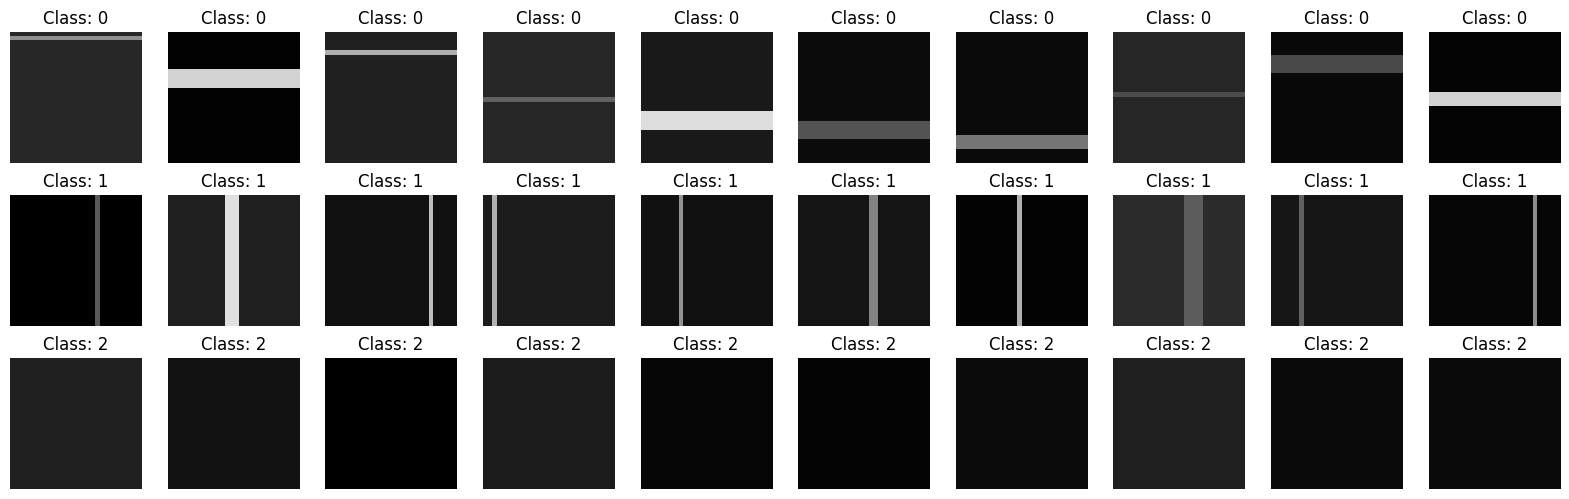

In [6]:
vis_dataset(visualize_dataset, num_classes=3, num_show_per_class=10)
plt.show()

## Q1. Overfitting Models to Small Dataset

In this problem, we will make our models overfit the small dataset to test the model architecture and our synthetic dataset. We use the same dataset for both models. Let's generate a small dataset with ten images per class.

In [8]:
set_seed(seed)

small_dataset_config = dict(
    data_per_class=10,
    num_classes=3,
    class_type=["horizontal", "vertical", "none"],
)
transforms = T.Compose([T.ToTensor()])
small_dataset = EdgeDetectionDataset(small_dataset_config, mode='train', transform=transforms)

In this notebook, we will use pytorch dataloader to load the dataset. We will use `torch.utils.data.DataLoader` to load the dataset. `DataLoader` takes two arguments: `dataset` and `batch_size`. `dataset` is the dataset that we want to load. Note that `batch_size` is one of important hyperparameters. We will use `batch_size=32` for this problem.

In [9]:
small_dataset_loader = DataLoader(small_dataset, batch_size=32, shuffle=True)

### Model Architecture

MLP has two hidden layer with 10 hidden units and 10 hidden units. The input size is 28x28=784 and the output size is 3. We use ReLU as the activation function. We use cross entropy loss as the loss function.

MLP architecture: FC(784, 10) -> ReLU -> FC(10, 10) -> ReLU -> FC(10, 3)

CNN has two convolutional layers followed by global average pooling and one fully connected layer. Both convolutional layers have 3 filters whose kernel size is 7. We use ReLU as the activation function. We use cross entropy loss as the loss function.

CNN arhitecture is as follows: CONV - RELU - MAXPOOL - CONV - RELU - MAXPOOL - FC

### Fitting on Small Dataset

Now let's train the model on the small dataset. The final tranining loss should be around 100% for both models.

In [10]:
set_seed(seed)

lr = 1e-2
num_epochs = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn_model = SimpleCNN(kernel_size=7)
cnn_model.to(device)
untrained_cnn_model = deepcopy(cnn_model)

mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
mlp_model.to(device)

mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

criterion = nn.CrossEntropyLoss()
print("CNN Model has {} parameters".format(count_parameters(cnn_model, only_trainable=True)))
print("MLP Model has {} parameters".format(count_parameters(mlp_model, only_trainable=True)))

for epoch in tqdm(range(num_epochs)):
    train_one_epoch(cnn_model, cnn_optimizer, criterion, small_dataset_loader, device, epoch, verbose=False)
    train_one_epoch(mlp_model, mlp_optimizer, criterion, small_dataset_loader, device, epoch, verbose=False)

_, cnn_acc, _ = evaluate(cnn_model, criterion, small_dataset_loader, device, verbose=False)
_, mlp_acc, _ = evaluate(mlp_model, criterion, small_dataset_loader, device, verbose=False)

print("CNN Acc: {}, MLP Acc: {}".format(cnn_acc, mlp_acc))

CNN Model has 606 parameters
MLP Model has 39793 parameters


100%|██████████| 500/500 [00:09<00:00, 51.58it/s]

CNN Acc: 100.0, MLP Acc: 100.0


We checked that both models can overfit the small dataset. This is one of the most important sanity check. If the model cannot overfit the small dataset, the model is not powerful enough to learn the dataset. In this case, we need to increase the size of the model.

### Visualize Learned Filters

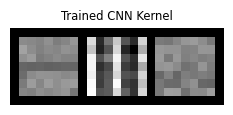

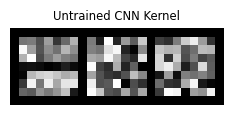

In [11]:
cnn_kernel = cnn_model.conv1.weight.data.clone().cpu()
untrained_kernel = untrained_cnn_model.conv1.weight.data.clone().cpu()

vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel')
vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel')


### Question

**Can you find any interesting patterns in the learned filters?** Answer this question in your submission of the written assignment.

**Ans**: The trained CNN kernel keeps some features which the untrained kernel already has. For the leftmost kernel, the black line in the center row is still the same, and other parts of the kernel are more blur. For the middle kernel, the white parts are rearrangeed to some white columns. And for the rightmost kernel, the relationship of values in the kernel are almost the same, only being averaged a little and become more grey instead of sharp black and white.

## Q2. Sweeping the Number of Training Images

We understood the given task and checked that both models had enough expressive power. We will compare the performance of MLP and CNN by changing the number of data per class. We expect that the model with proper inductive biases on this task will fit with **fewer training examples**. And let's see which one has inductive biases. In this problem, we will use the same dataset for both models. We sweep the number of training images from 10 to 500. The validation set will be the same for all the experiments.

In [17]:
set_seed(seed)

transforms = T.Compose([T.ToTensor()])
train_loader_dict = dict()
train_batch_size = 10
valid_batch_size = 256

for i in [5, 10, 30, 50, 100]:
  train_data_config_i = dict(
      data_per_class=i,
      num_classes=3,
      class_type=["horizontal", "vertical", "none"],
  )
  train_dataset_i = EdgeDetectionDataset(train_data_config_i, mode='train', transform=transforms)
  train_dataset_loader_i = DataLoader(train_dataset_i, batch_size=train_batch_size, shuffle=True)
  train_loader_dict[i] = train_dataset_loader_i

num_images_list = [5, 10, 30, 50, 100]
valid_loader = None

valid_data_config = dict(
      data_per_class=50,
      num_classes=3,
      class_type=["horizontal", "vertical", "none"],
)

valid_dataset = EdgeDetectionDataset(valid_data_config, mode='valid', transform=transforms)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True)

# print(train_loader_dict)
# print(valid_loader)

In [18]:
lr = 1e-2
num_epochs = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    for epoch in tqdm(range(num_epochs)):
        train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)
        train_one_epoch(mlp_model, mlp_optimizer, criterion, train_loader, device, epoch, verbose=False)

    cnn_kernel_dict[num_image] = deepcopy(cnn_model.conv1.weight.cpu().detach())
    untrained_cnn_kernel_dict[num_image] = deepcopy(untrained_cnn_model.conv1.weight.cpu().detach())

    _, cnn_valid_acc, _ = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)
    _, mlp_valid_acc, _ = evaluate(mlp_model, criterion, valid_loader, device, verbose=False)

    print("CNN Acc: {}, MLP Acc: {}".format(cnn_valid_acc, mlp_valid_acc))
    cnn_acc_list.append(cnn_valid_acc)
    mlp_acc_list.append(mlp_valid_acc)

Training with 5 images


100%|██████████| 30/30 [00:00<00:00, 63.60it/s]


CNN Acc: 46.0, MLP Acc: 46.666666666666664
Training with 10 images


100%|██████████| 30/30 [00:00<00:00, 38.79it/s]


CNN Acc: 52.666666666666664, MLP Acc: 47.333333333333336
Training with 30 images


100%|██████████| 30/30 [00:02<00:00, 13.52it/s]


CNN Acc: 76.0, MLP Acc: 75.33333333333333
Training with 50 images


100%|██████████| 30/30 [00:03<00:00,  8.04it/s]


CNN Acc: 84.0, MLP Acc: 78.0
Training with 100 images


100%|██████████| 30/30 [00:07<00:00,  3.76it/s]

CNN Acc: 94.0, MLP Acc: 94.0


<Figure size 1000x800 with 0 Axes>

<Figure size 600x600 with 0 Axes>

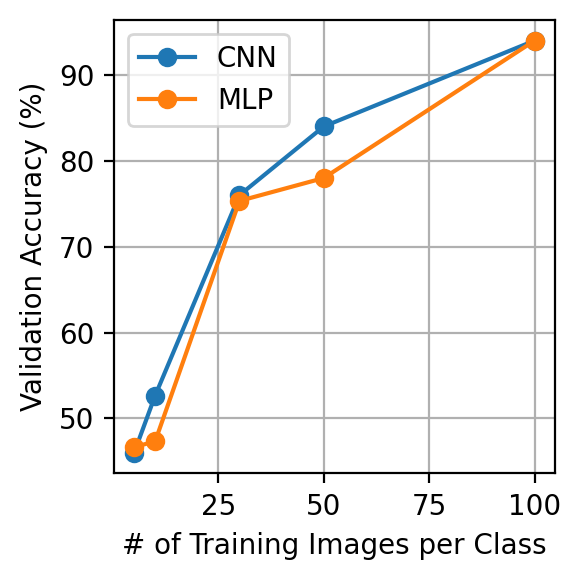

In [19]:
## Plot the validation accuracy
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
ax.plot(num_images_list, cnn_acc_list, marker='o', label='CNN')
ax.plot(num_images_list, mlp_acc_list, marker='o', label='MLP')
ax.set_xlabel('# of Training Images per Class')
ax.set_ylabel('Validation Accuracy (%)')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

OK, in most cases, CNN looks like it is performing better than MLP. So can we conclude that CNN has the inductive biases of locality and translational invariance? Not yet. We need to conduct a series of other experiments to show that CNN has such inductive biases.



Seemingly, the experiment result is odd. First, the performance of the low data regime ```num_train_images_per_class=10``` is very bad, considering the task is straightforward. Second, we observe that the performance of MLP is better than CNN at some point. At least, CNN should be much better even in a small data regime if it is translational equivariant. How do we debug the model? We will study how to debug the model in the following problem.

Here are some checklists that you can do to debug the problem.

1. Did you check the dataset? For example, is the dataset balanced? Is the dataset noisy? Is the dataset too small?
2. Did you check the model architecture? For example, is the model architecture powerful enough to learn the dataset? Is the model architecture too complex? Is the model architecture too simple?
3. Did you check the model initialization? For example, is the model initialized properly? Is the model initialized randomly? Is the model initialized with the pre-trained weights?
4. Did you check that the model is trained correctly? For example, does the kernel look like an edge detector? What would be the performance of CNN if kernels were initialized with edge detectors?
5. Did you check the training procedure? For example, is the training procedure correct? Is the training procedure stable? Is the training procedure too slow?
6. Did you optimize the hyperparameters? For example, learning rate, batch size, and the number of epochs.

Note that we already checked the dataset, initialization, and model architecture. But we didn't check the step after 3. Let's step 4 first. We will first see what the learned weights look like, initialize the kernels with edge detectors, and see what happens.

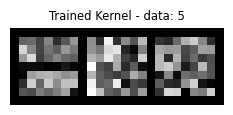

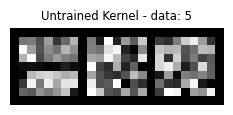

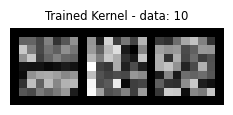

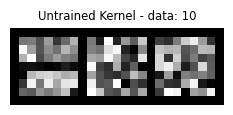

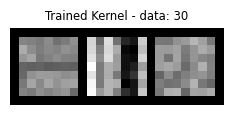

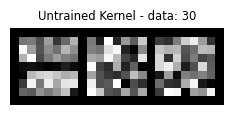

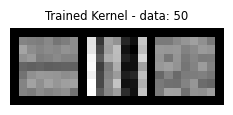

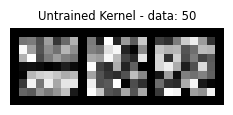

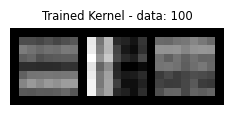

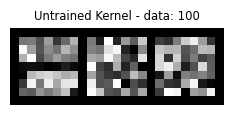

In [20]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained Kernel - data: {}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained Kernel - data: {}'.format(num_image))
plt.show()

#### Question

**Compare the learned kernels, untrainable kernels, and edge-detector kernels. What do you observe?**

**Ans**: The trained kernel is very similar to the untrained kernel when the data's size is rather small. As the size of data growing, the trained kernel becomes more arranged: the leftmost one keeps the black center row and blurs other parts to grey, the middle one has sharp white and black columns and the rightmost one simply blurs the original kernel.

### Injecting Inductive Bias: Initialize Kernels with Edge Detectors

In [21]:
lr = 1e-2
num_epochs = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

edge_init_cnn_acc_list = list()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    cnn_model = SimpleCNN(kernel_size=7)
    init_conv_kernel_with_edge_detector(cnn_model)
    freeze_conv_layer(cnn_model)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    # logging how training and validation accuracy changes
    edge_init_cnn_valid_acc_list = []
    for epoch in tqdm(range(num_epochs)):
        cnn_train_loss, cnn_train_acc = train_one_epoch(cnn_model, cnn_optimizer, criterion, train_loader, device, epoch, verbose=False)

    _, cnn_valid_acc, _ = evaluate(cnn_model, criterion, valid_loader, device, verbose=False)
    print("CNN Acc: {}".format(cnn_valid_acc))
    edge_init_cnn_acc_list.append(cnn_valid_acc)


Training with 5 images


100%|██████████| 30/30 [00:00<00:00, 128.65it/s]


CNN Acc: 91.33333333333333
Training with 10 images


100%|██████████| 30/30 [00:00<00:00, 83.02it/s]


CNN Acc: 90.66666666666667
Training with 30 images


100%|██████████| 30/30 [00:00<00:00, 30.94it/s]


CNN Acc: 90.66666666666667
Training with 50 images


100%|██████████| 30/30 [00:01<00:00, 15.01it/s]


CNN Acc: 91.33333333333333
Training with 100 images


100%|██████████| 30/30 [00:02<00:00, 11.09it/s]

CNN Acc: 91.33333333333333


<Figure size 1000x800 with 0 Axes>

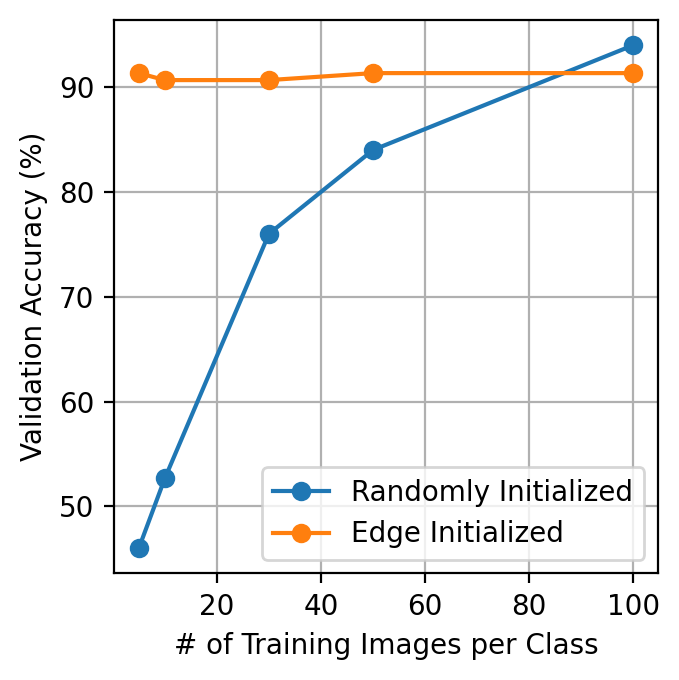

In [22]:
## Plot the validation accuracy
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=200)
plt.plot(num_images_list, cnn_acc_list, marker='o', label='Randomly Initialized')
plt.plot(num_images_list, edge_init_cnn_acc_list, marker='o', label='Edge Initialized')
ax.set_xlabel('# of Training Images per Class')
ax.set_ylabel('Validation Accuracy (%)')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()


### Question

We freeze the convolutional layer and train only final layer (classifier) in this experiment. For a high data regime, the performance of CNN initialized with edge detectors is worse than CNN initialized with random weights. **Why do you think this happens?** Answer this question in your submission of the written assignment.

**Ans**: I think the CNN initialized with edge detector have too much "inductive bias" and starts with a very high level acc. However, this high inductive bias also restricts its further performance and improvement because it tends to follow the preferred way and thus hardly improves.

## Q3. Checking the Training Procedure

Checking the training procedure is very important. We must log at least training loss, training accuracy, validation loss, and validation accuracy. Let's log such training signals and find out what is going on.

Training with 5 images


100%|██████████| 30/30 [00:01<00:00, 26.02it/s]


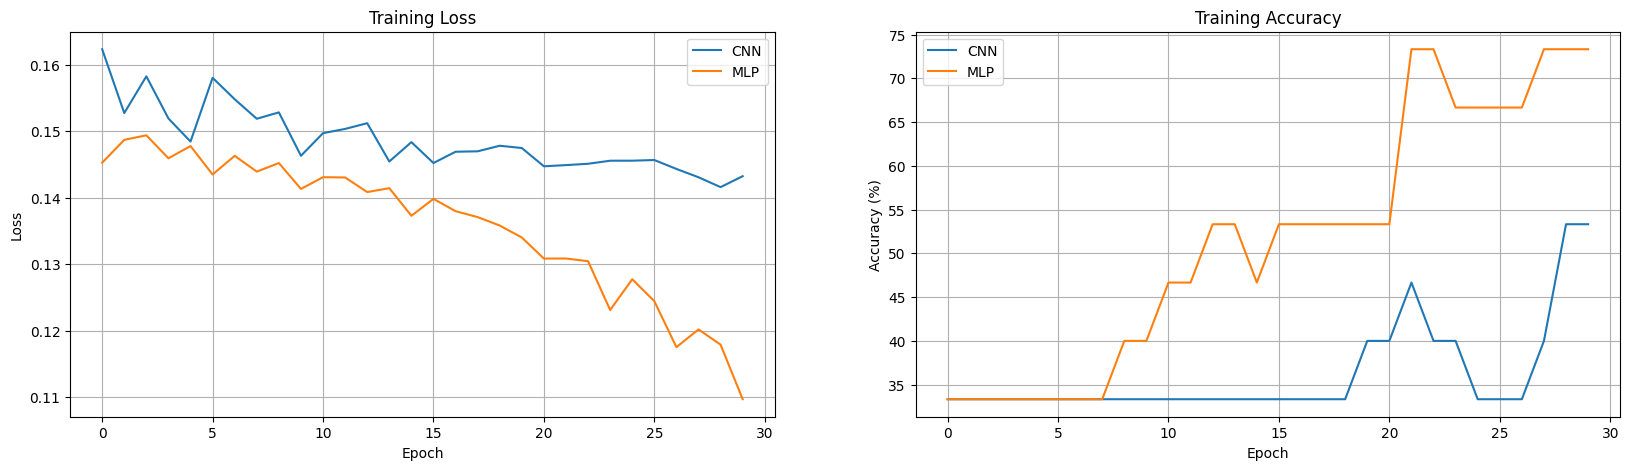

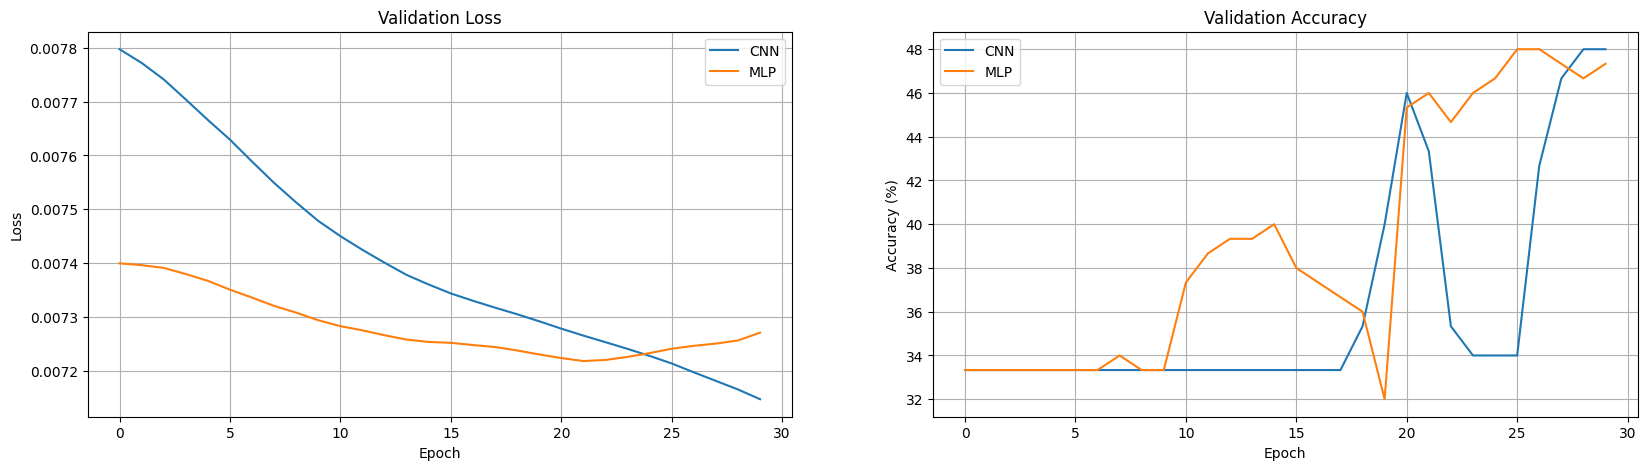

CNN Acc: 48.0, MLP Acc: 47.333333333333336
Training with 10 images


100%|██████████| 30/30 [00:02<00:00, 13.95it/s]


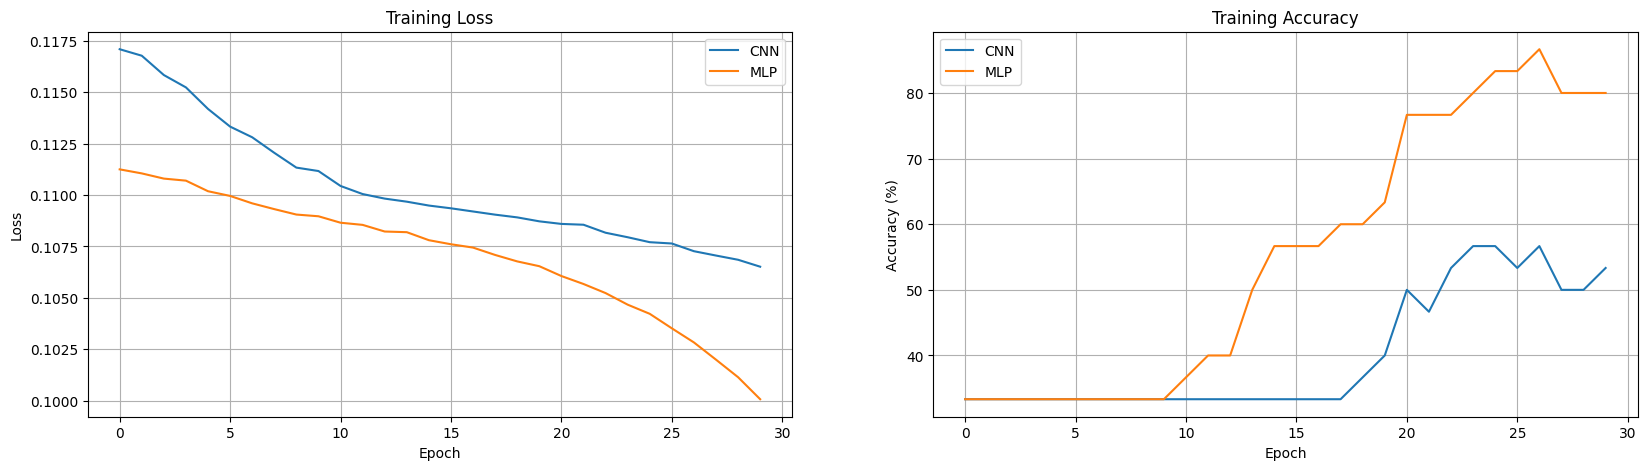

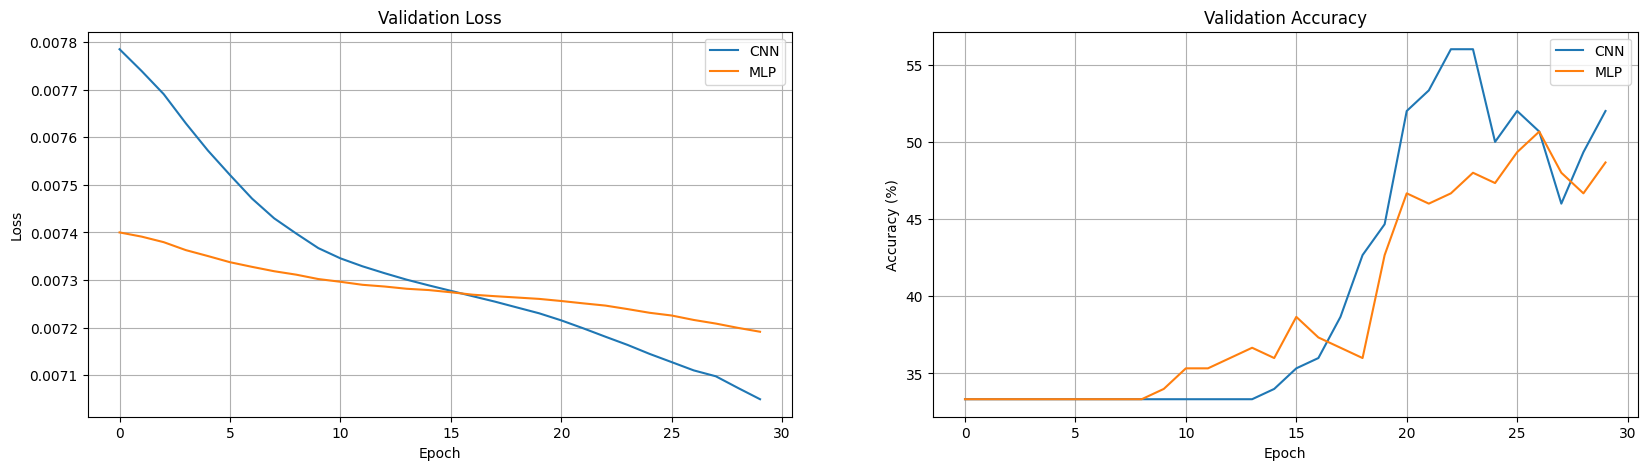

CNN Acc: 52.0, MLP Acc: 48.666666666666664
Training with 30 images


100%|██████████| 30/30 [00:02<00:00, 12.12it/s]


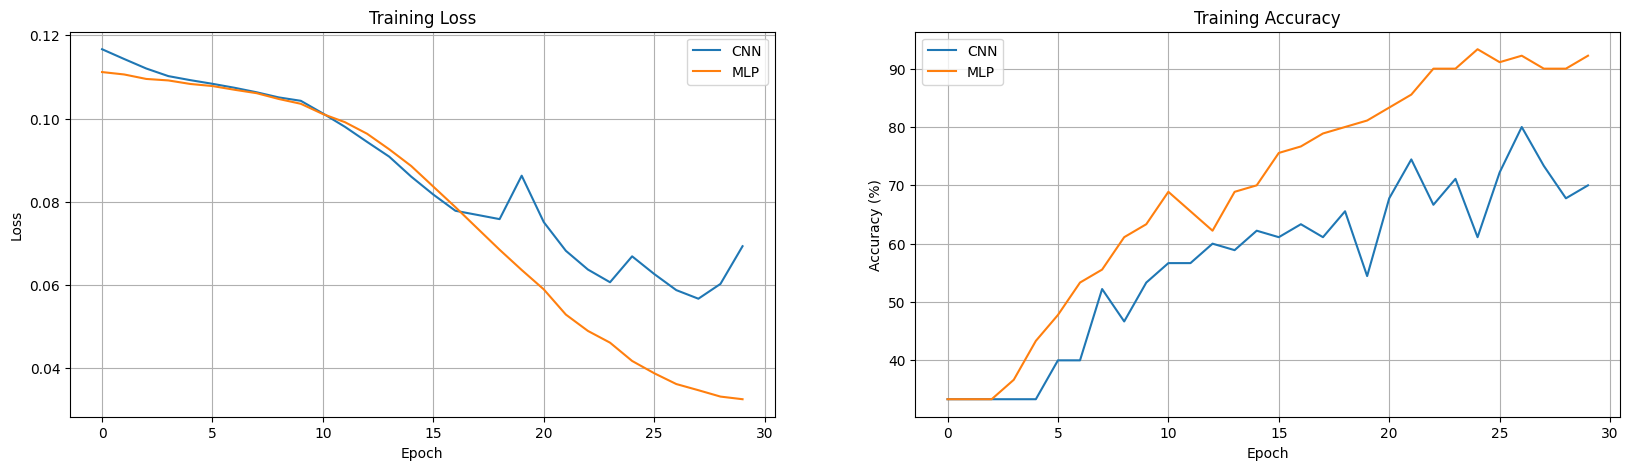

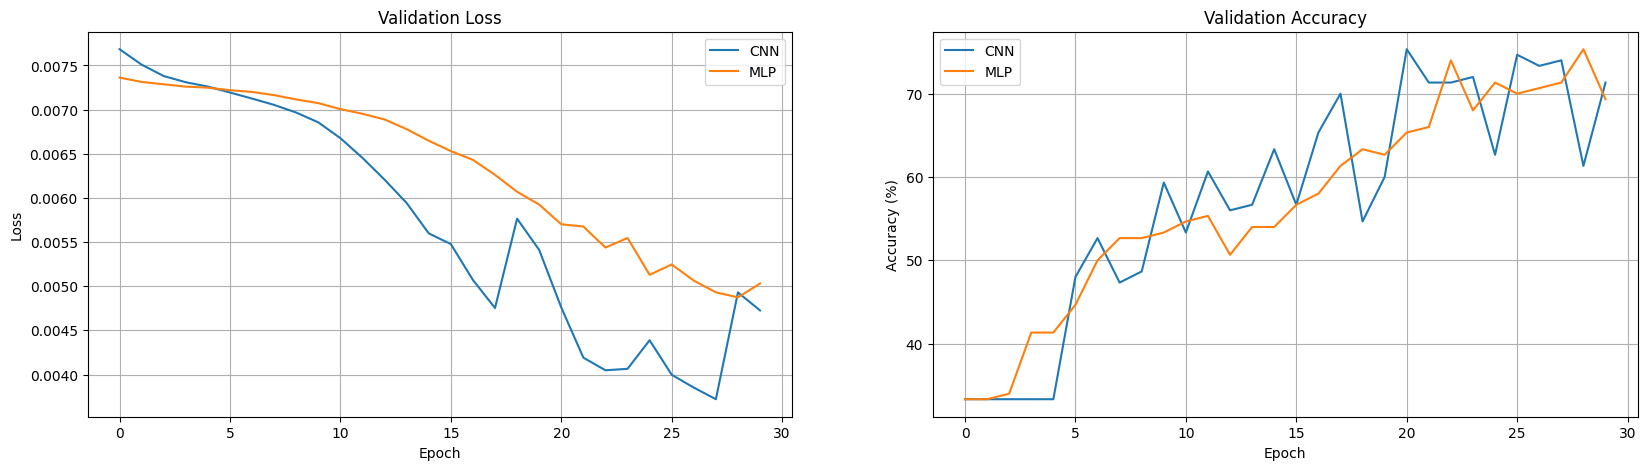

CNN Acc: 71.33333333333333, MLP Acc: 69.33333333333333
Training with 50 images


100%|██████████| 30/30 [00:03<00:00,  8.58it/s]


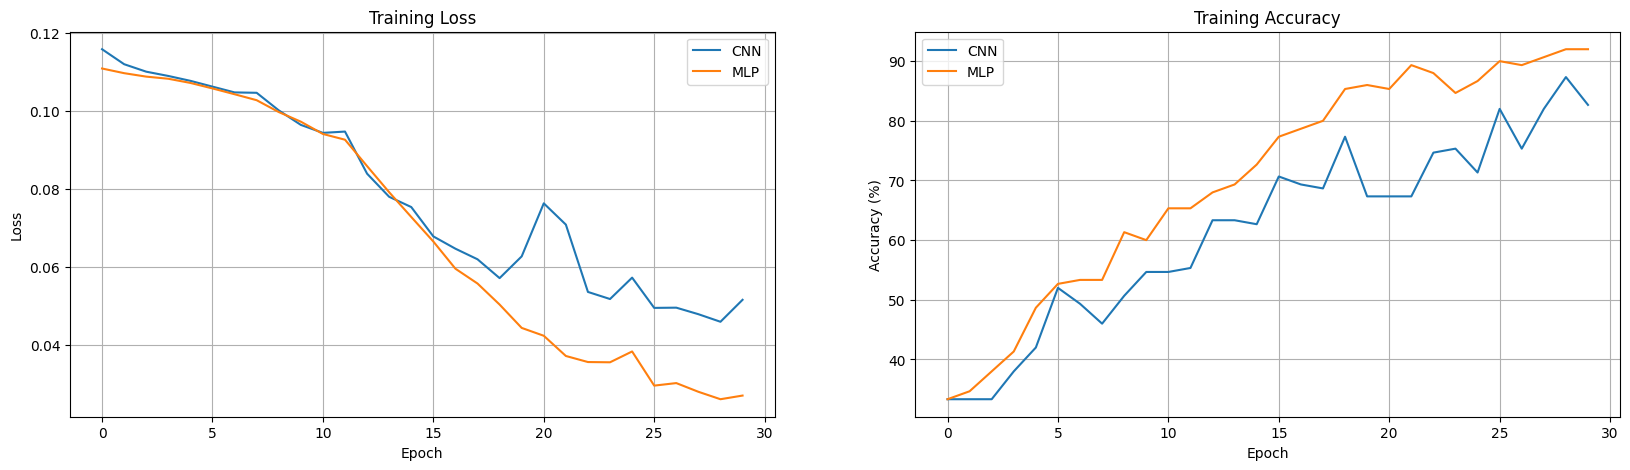

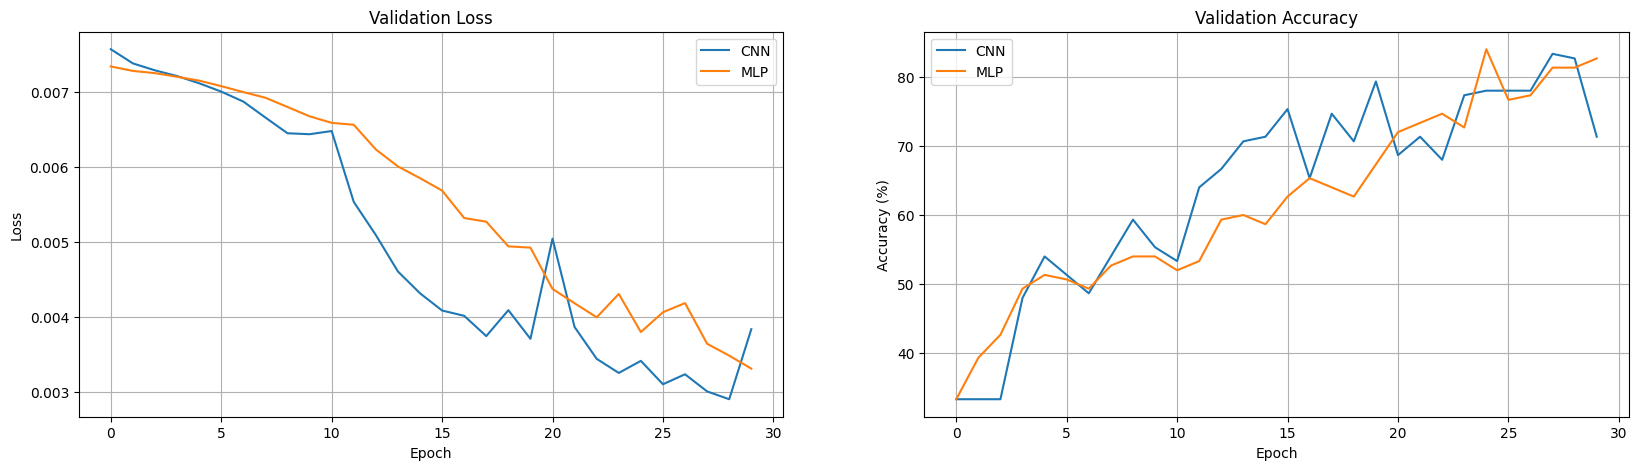

CNN Acc: 71.33333333333333, MLP Acc: 82.66666666666667
Training with 100 images


100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


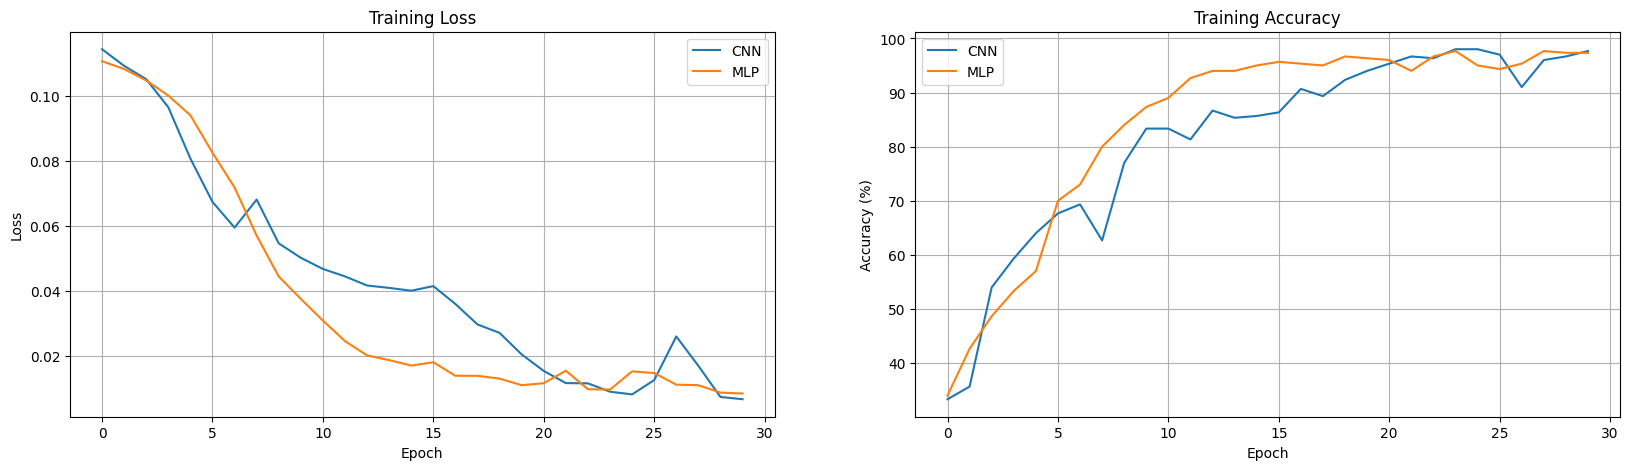

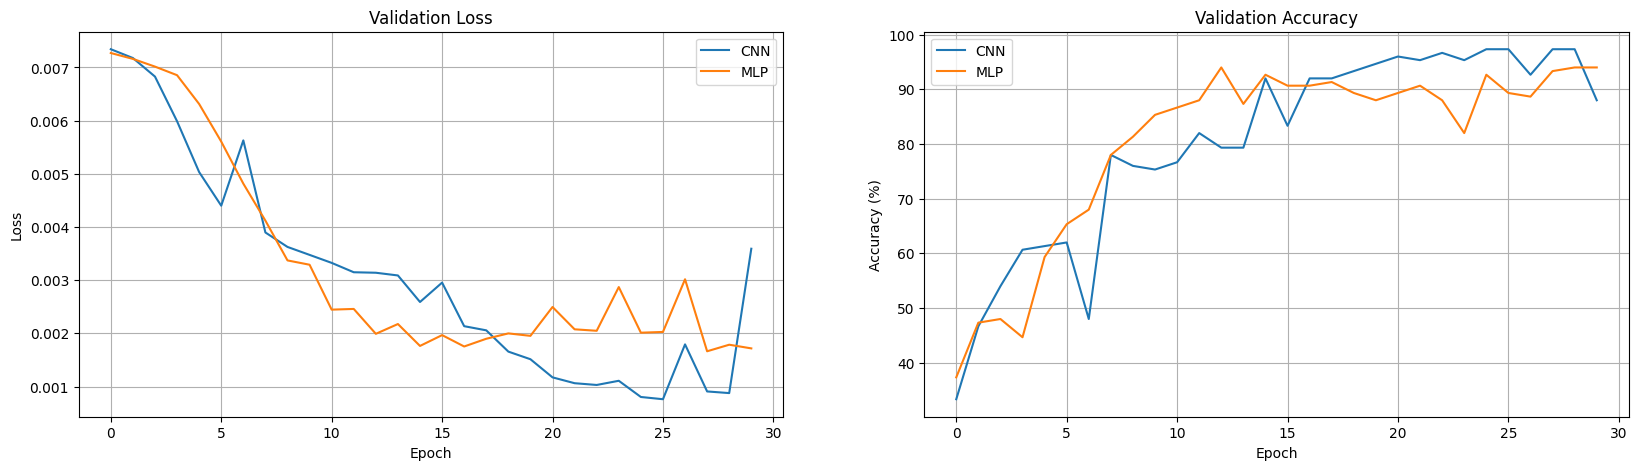

CNN Acc: 88.0, MLP Acc: 94.0


In [23]:
def train_model(model, optimizer, num_epochs, train_loader, valid_loader):
    criterion=nn.CrossEntropyLoss()
    untrained_model = deepcopy(model)
    train_acc_list, valid_acc_list, train_loss_list, valid_loss_list = [], [], [] ,[]
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device, epoch, verbose=False)
        valid_loss, valid_acc, confusion_matrix = evaluate(model, criterion, valid_loader, device, verbose=False)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

    return {"final_valid_acc": valid_acc_list[-1], "train_acc": train_acc_list, "valid_acc": valid_acc_list,
            "train_loss": train_loss_list, "valid_loss": valid_loss_list,
            "confusion_matrix": confusion_matrix}


lr = 1e-2
num_epochs = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    mlp_results = train_model(mlp_model, mlp_optimizer, num_epochs, train_loader, valid_loader)
    cnn_results = train_model(cnn_model, cnn_optimizer, num_epochs, train_loader, valid_loader)

    vis_training_curve(cnn_results["train_loss"], cnn_results["train_acc"], mlp_results["train_loss"], mlp_results["train_acc"])
    vis_validation_curve(cnn_results["valid_loss"], cnn_results["valid_acc"], mlp_results["valid_loss"], mlp_results["valid_acc"])

    print("CNN Acc: {}, MLP Acc: {}".format(cnn_results["final_valid_acc"], mlp_results["final_valid_acc"]))

What is going on here? Validation loss and validation accuracy are not flat at the end. It means that the model is not converged. We need to train the model more. Let's train the model with the higher number of epochs. Increase the number of epochs until the validation loss and accuracy are flat.

#### Question

**List every epochs that you trained the model.** Final accuracy of CNN should be at least 95% for 30 images per class. Answer this question in your submission of the written assignment.

#### Question

**Check the learned kernels. What do you observe?** Answer this question in your submission of the written assignment.

#### Question (Optional)

You might find that with the high number of epochs, validation loss of MLP is increasing while validation accuracy increasing.  **How can we interpret this?** Answer this question in your submission of the written assignment.

(Hint: you may find papers that discuss calibrations related to this question (e.g., [paper](https://arxiv.org/pdf/1706.04599.pdf))

#### Question (Optional)

Do hyperparameter tuning. **And list the best hyperparameter setting that you found and report the final accuracy of CNN and MLP.** Answer this question in your submission of the written assignment.

Training with 5 images


100%|██████████| 150/150 [00:06<00:00, 22.48it/s]


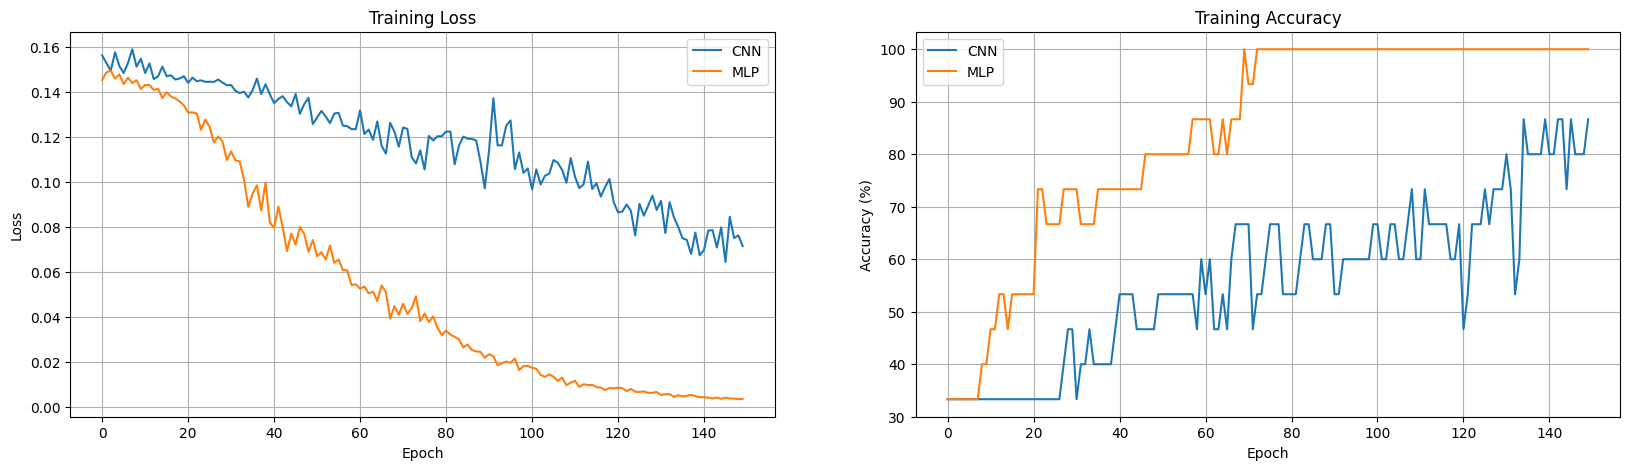

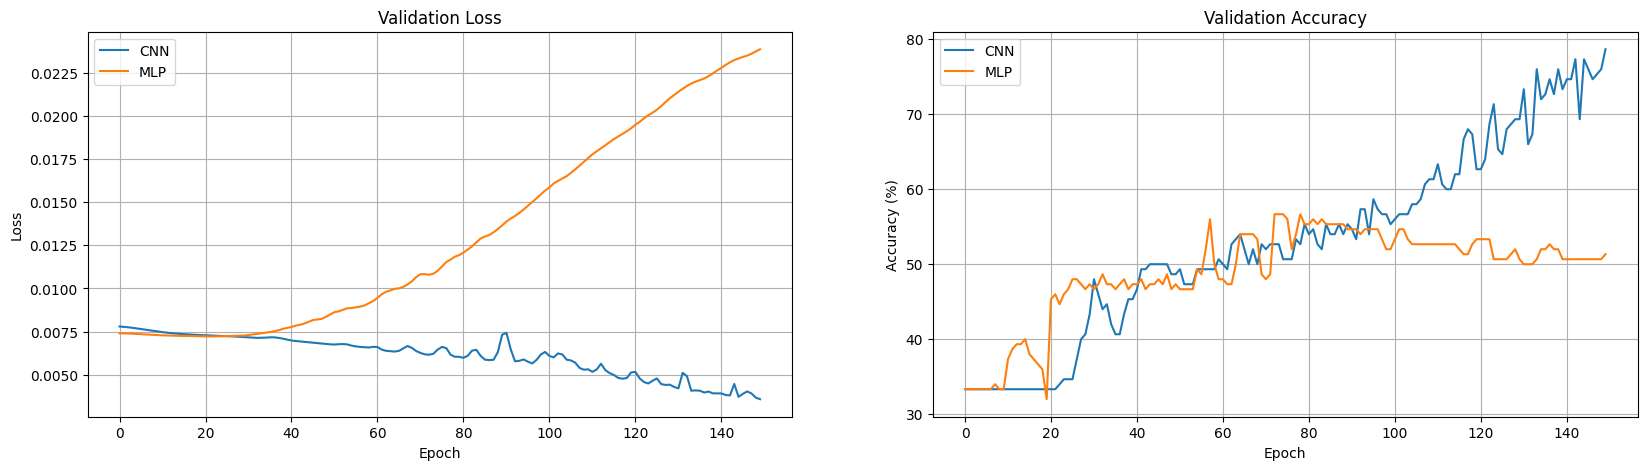

CNN Acc: 78.66666666666667, MLP Acc: 51.333333333333336
Training with 10 images


100%|██████████| 150/150 [00:07<00:00, 18.82it/s]


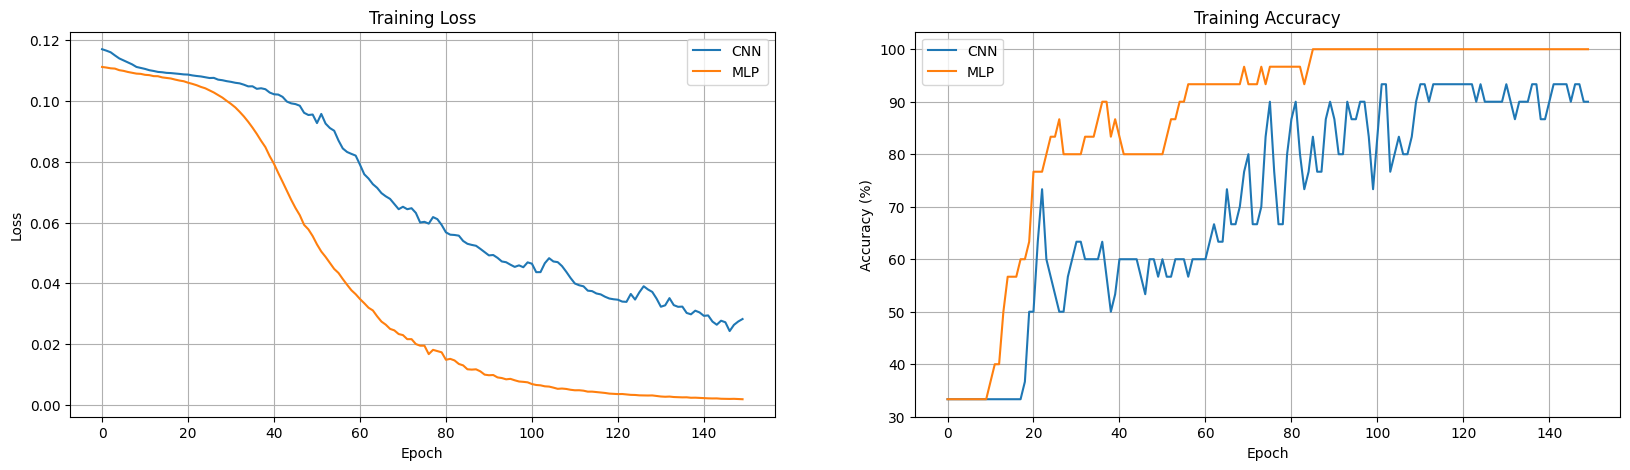

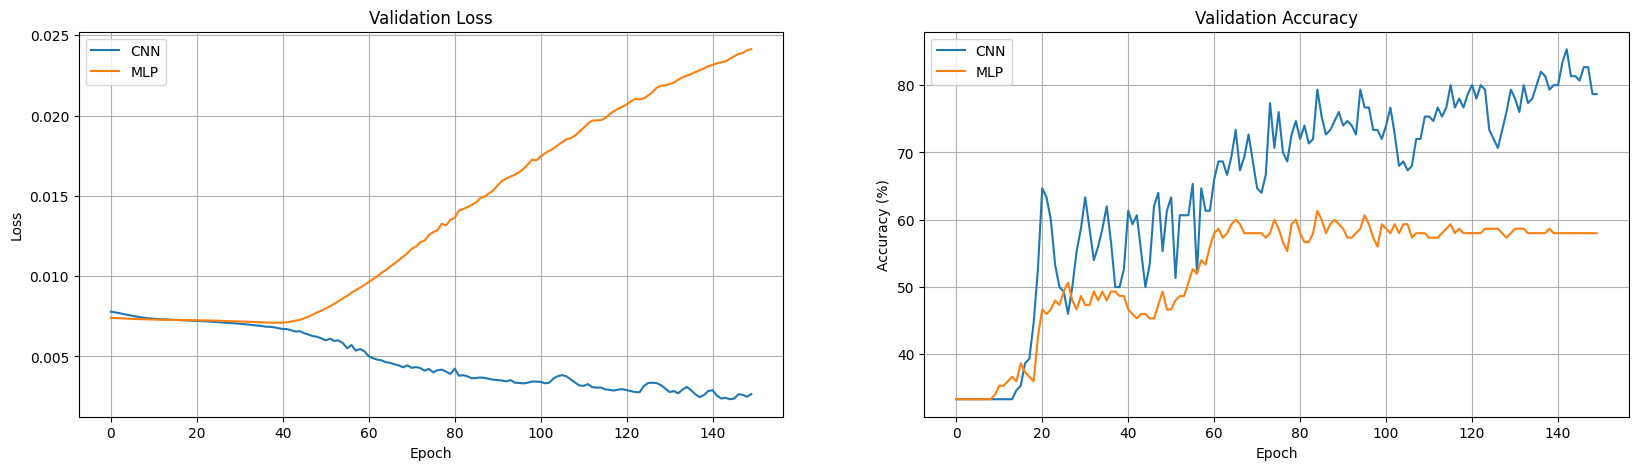

CNN Acc: 78.66666666666667, MLP Acc: 58.0
Training with 30 images


100%|██████████| 150/150 [00:13<00:00, 11.18it/s]


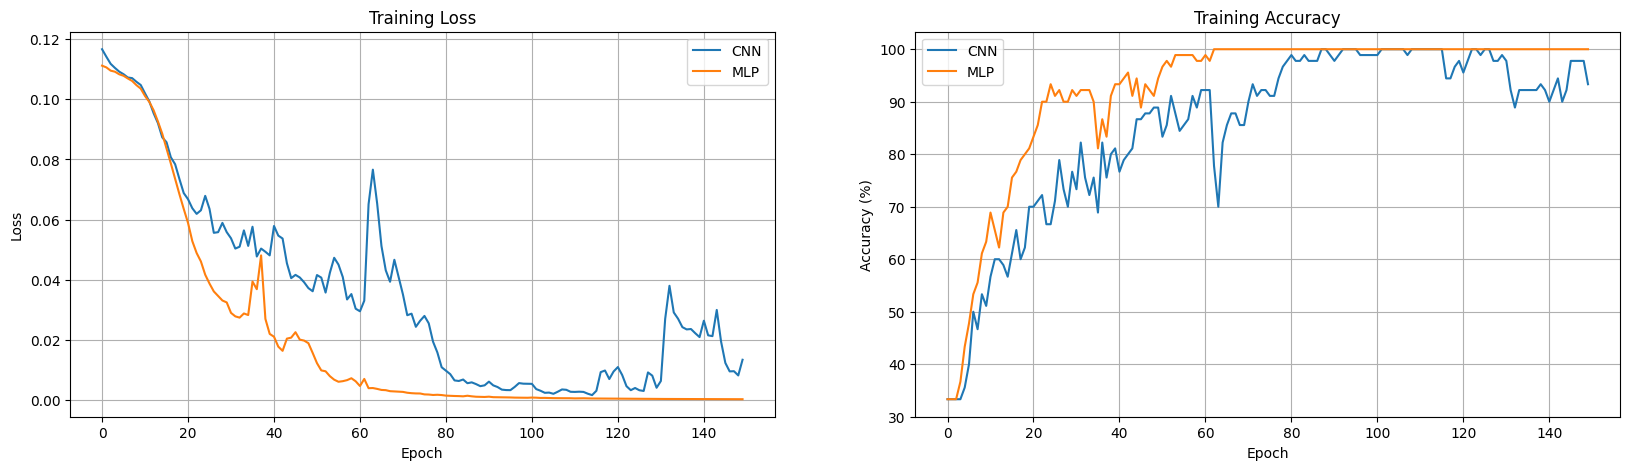

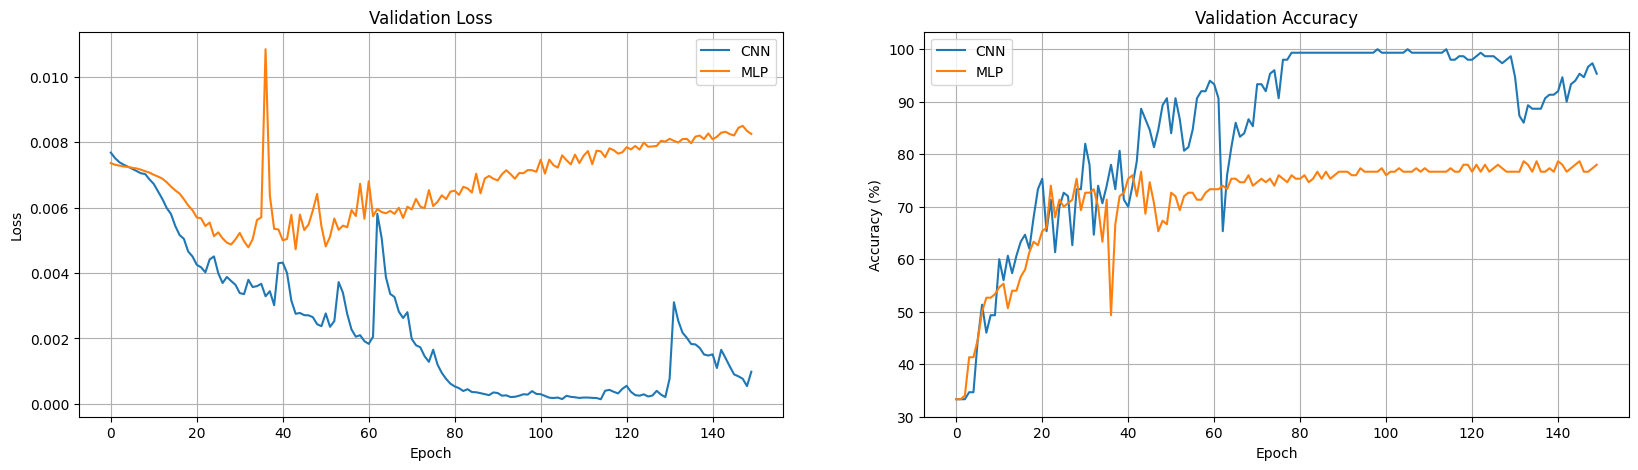

CNN Acc: 95.33333333333333, MLP Acc: 78.0
Training with 50 images


100%|██████████| 150/150 [00:19<00:00,  7.71it/s]


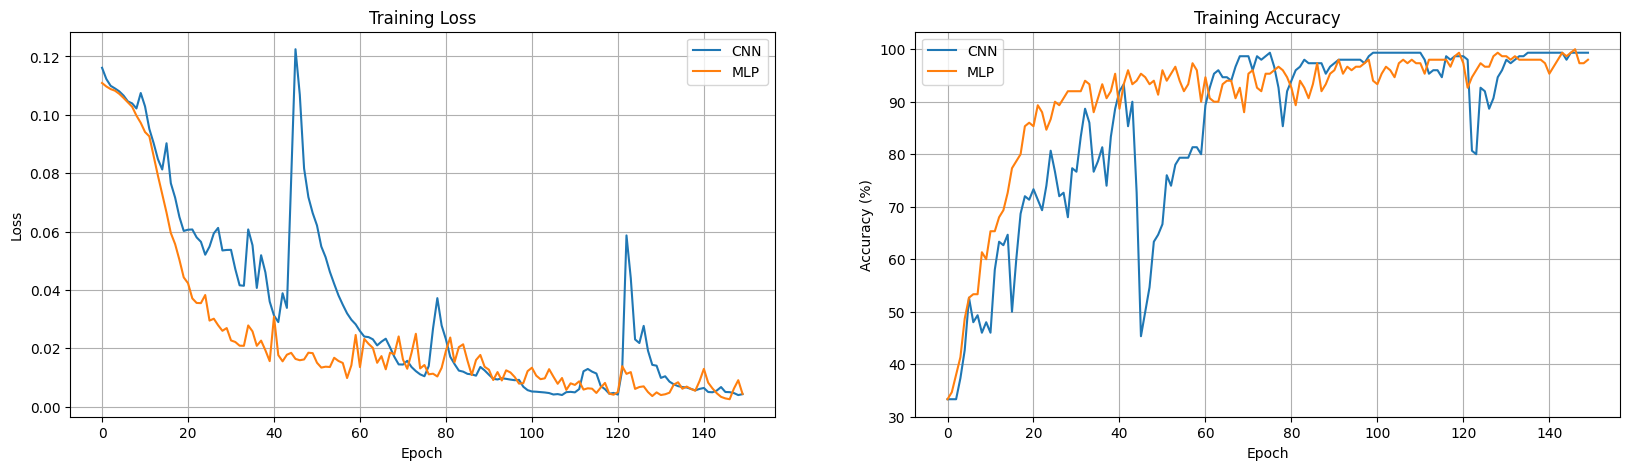

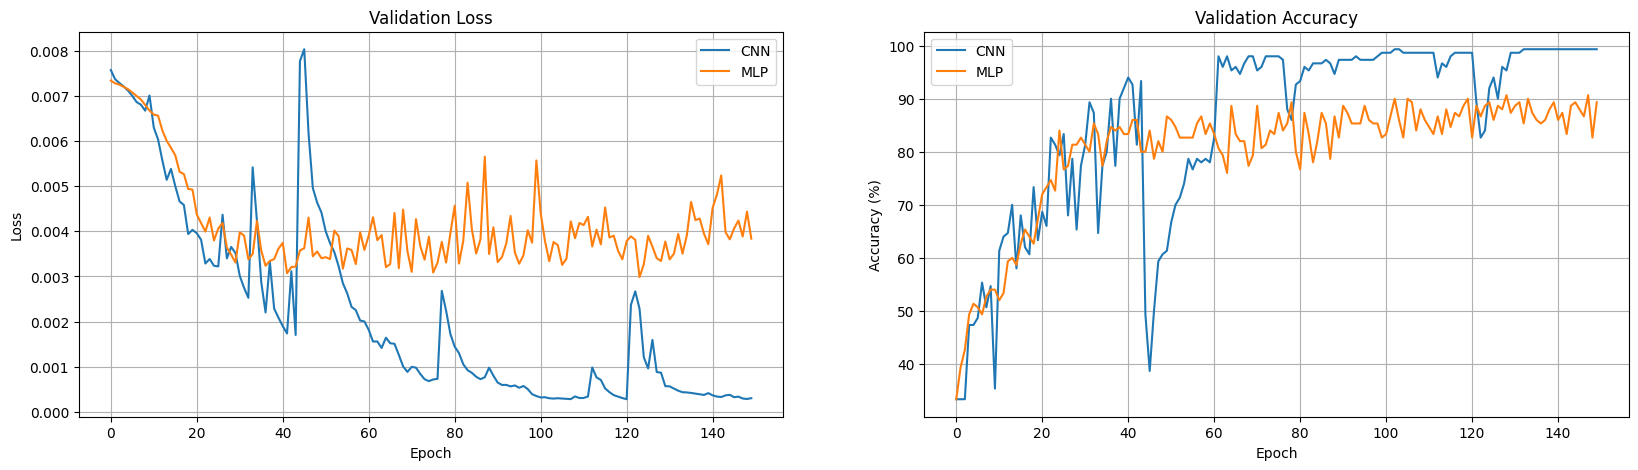

CNN Acc: 99.33333333333333, MLP Acc: 89.33333333333333
Training with 100 images


100%|██████████| 150/150 [00:39<00:00,  3.77it/s]


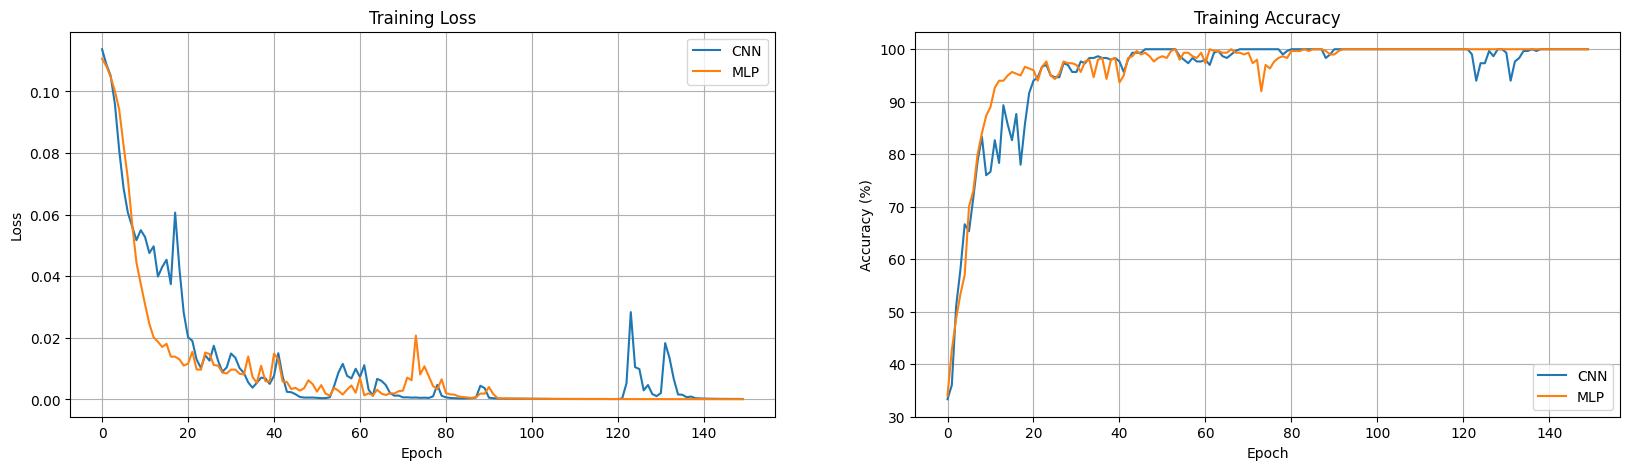

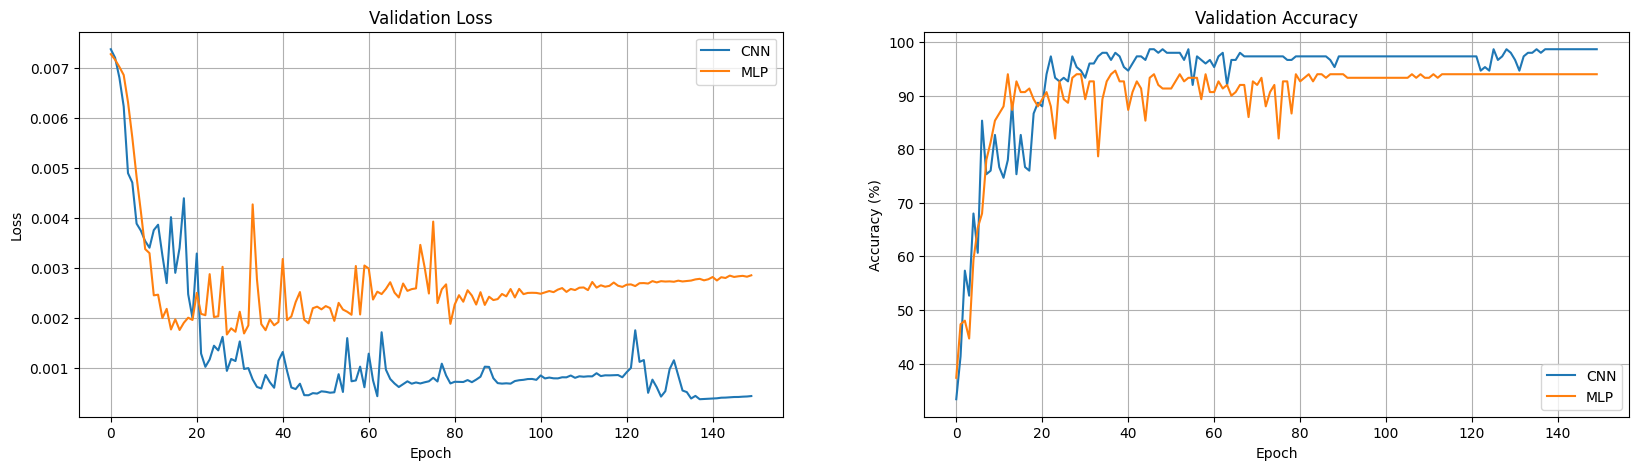

CNN Acc: 98.66666666666667, MLP Acc: 94.0


In [25]:
lr = 1e-2
num_epochs = 150
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    mlp_results = train_model(mlp_model, mlp_optimizer, num_epochs, train_loader, valid_loader)
    cnn_results = train_model(cnn_model, cnn_optimizer, num_epochs, train_loader, valid_loader)

    vis_training_curve(cnn_results["train_loss"], cnn_results["train_acc"], mlp_results["train_loss"], mlp_results["train_acc"])
    vis_validation_curve(cnn_results["valid_loss"], cnn_results["valid_acc"], mlp_results["valid_loss"], mlp_results["valid_acc"])

    cnn_kernel_dict[num_image] = deepcopy(cnn_model.conv1.weight.data.detach().cpu())
    untrained_cnn_kernel_dict[num_image] = deepcopy(untrained_cnn_model.conv1.weight.data.detach().cpu())

    print("CNN Acc: {}, MLP Acc: {}".format(cnn_results["final_valid_acc"], mlp_results["final_valid_acc"]))

In [ ]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel {}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel {}'.format(num_image))
plt.show()

#### Question

**How much more data is needed for MLP to get a competitive performance with CNN?** Answer this question in your submission of the written assignment.

## Q4. Domain Shift between Training and Validation Set

In this problem, we will see how the model performance changes when the domain of the training set and that of the validation set are different. We will generate training set images with edges that locate only half of the image and validation set images with edges that locate only the other half of the image. Let's repeat the same experiment as the previous problem.

In [ ]:
set_seed(seed)
train_loader_dict = dict()
num_train_images_list = [10, 30, 50, 100]
possible_edge_location_ratio = 0.5
valid_loader = None

transforms = T.Compose([T.ToTensor()])
batch_size = 10

for num_image in num_train_images_list:
    train_dataset_config = dict(
        data_per_class=num_image,
        possible_edge_location_ratio=possible_edge_location_ratio,
    )
    train_dataset = EdgeDetectionDataset(train_dataset_config, 'train', transform=transforms)
    train_loader_dict[num_image] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset_config = dict(
    data_per_class=50,
    possible_edge_location_ratio=possible_edge_location_ratio,
)
valid_dataset = EdgeDetectionDataset(valid_dataset_config, 'valid', transform=transforms)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
lr = 1e-2
num_epochs = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_acc_list = list()
mlp_acc_list = list()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict()

cnn_confusion_matrix_dict = dict()
mlp_confusion_matrix_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    mlp_results = train_model(mlp_model, mlp_optimizer, num_epochs, train_loader, valid_loader)
    cnn_results = train_model(cnn_model, cnn_optimizer, num_epochs, train_loader, valid_loader)

    vis_training_curve(cnn_results["train_loss"], cnn_results["train_acc"], mlp_results["train_loss"], mlp_results["train_acc"])
    vis_validation_curve(cnn_results["valid_loss"], cnn_results["valid_acc"], mlp_results["valid_loss"], mlp_results["valid_acc"])

    cnn_kernel_dict[num_image] = deepcopy(cnn_model.conv1.weight.detach().cpu())
    untrained_cnn_kernel_dict[num_image] = deepcopy(untrained_cnn_model.conv1.weight.detach().cpu())

    cnn_confusion_matrix_dict[num_image] = cnn_results["confusion_matrix"]
    mlp_confusion_matrix_dict[num_image] = mlp_results["confusion_matrix"]

    print("CNN Acc: {}, MLP Acc: {}".format(cnn_results["final_valid_acc"], mlp_results["final_valid_acc"]))

In [ ]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel Data={}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel Data={}'.format(num_image))
plt.show()

In this example, you will see that both CNN and MLP performance are worse than those in the previous question. If two models learn how to extract edges, they should be able to classify the images with edges even though the edges locate in the other half of the images. However, both models suffer from performance degration (especially for MLP). What would be the problem? To investigate this, let's first look at the confusion matrices for both models  [link](https://en.wikipedia.org/wiki/Confusion_matrix).

In [ ]:
## Plot the confusion matrix
for num_image, cnn_confusion_matrix in cnn_confusion_matrix_dict.items():
    mlp_confusion_matrix = mlp_confusion_matrix_dict[num_image]
    vis_confusion_matrix(cnn_confusion_matrix, ['horizontal', 'vertical', 'none'], 'CNN-{}-images'.format(num_image))
    vis_confusion_matrix(mlp_confusion_matrix, ['horizontal', 'vertical', 'none'], 'MLP-{}-images'.format(num_image))
plt.show()

#### Question

**Why do you think the confusion matrix looks like this?** Answer this question in your submission of the written assignment.

(Hint: Visualize some of the images in the training and validation set. And we are using kernel_size=7, which is large relative to the image size.)

We can do better than this. We didn't explore hyperparameter space yet. Let's search hyperparameters that can generalize well to the validation set. We will change the learning rate, the number of epochs, and kernel size for CNN.

In [ ]:
#############################################################################
# TODO: Try other num_epochs, lr, kernel_size. The validation accuracy      #
# should achieve around 97-100% for 10 images per class.                    #
#############################################################################
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_valid_acc_list = list()

cnn_kernel_dict = dict()

cnn_confusion_matrix_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=kernel_size)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    cnn_results = train_model(cnn_model, cnn_optimizer, num_epochs, train_loader, valid_loader)

    vis_training_curve(cnn_results["train_loss"], cnn_results["train_acc"], None, None)
    vis_validation_curve(cnn_results["valid_loss"], cnn_results["valid_acc"], None, None)

    print("CNN Acc: {}".format(cnn_results["final_valid_acc"]))

#### Question

**Why do you think MLP fails to learn the task while CNN can learn the task?** Answer this question in your submission of the written assignment.

(Hint: Think about the model architecture.)

## Q5. When is CNN Worse than MLP?

In this problem, we will see that CNN is not always better than MLP in the image domain. Using CNN assumes that the data has locally correlated, whatever data looks. We can manually 'whiten' or remove such local correlation simply by applying random permutation to the images. A random permutation matrix is a matrix that has the same number of rows and columns. Each row and column has the same number of 1s. The rest of the elements are 0s. For example, the following is a random permutation matrix.

```
[[0, 1, 0, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 0, 1, 0]]
```

This matrix randomly reorders the elements of the vector. For example, if we apply this matrix to the vector `[1, 2, 3, 4]`, we will get `[2, 4, 1, 3]`. If we apply this matrix to the image, we will get the image with the same content, but the pixels are randomly shuffled. One property of the random permutation matrix is that it is invertible. It means that we can recover the original image by simply applying the inverse matrix to the shuffled image. From the information-theoretical perspective, the random permutation matrix preserves the mutual information of the image and the label.

We will repeat the same experiment as the previous problem. Visualize the dataset first.

In [ ]:
set_seed(seed)
visual_domain_config = None
use_permutation = True

permutater = np.arange(28 * 28,  dtype=np.int32)
np.random.shuffle(permutater)
unpermutater = np.argsort(permutater)

visual_dataset = None

transforms = T.Compose([T.ToTensor()])

visual_domain_config = dict(
    data_per_class=10,
    use_permutation=True,
    permutater=permutater,
    unpermutater=unpermutater,
)
visual_dataset = EdgeDetectionDataset(visual_domain_config, mode='train', transform=transforms)

In [ ]:
## Visualize the images
unpermutator = visual_dataset.get_unpermutater()
print('Dataset Image before permutation')
vis_unpermuted_dataset(visual_dataset, num_classes=3, num_show_per_class=10, unpermutator=unpermutator)

print('Dataset Image after permutation')
vis_dataset(visual_dataset, num_classes=3, num_show_per_class=10)

plt.show()

Now let's train CNN and MLP on the permuted dataset.

In [ ]:
set_seed(seed)

train_loader_dict = dict()
num_train_images_list = [10, 30, 50, 100]
use_permutation = True
valid_loader = None

permutater = np.arange(28 * 28,  dtype=np.int32)
np.random.shuffle(permutater)
unpermutater = np.argsort(permutater)

transforms = T.Compose([T.ToTensor()])

batch_size = 10

for num_image in num_train_images_list:
    train_dataset_config = dict(
        data_per_class=num_image,
        use_permutation=True,
        permutater=permutater,
        unpermutater=unpermutater,
    )
    train_dataset = EdgeDetectionDataset(train_dataset_config, 'train', transform=transforms)
    train_loader_dict[num_image] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset_config = dict(
    data_per_class=50,
    use_permutation=True,
    permutater=permutater,
    unpermutater=unpermutater,
)
valid_dataset = EdgeDetectionDataset(valid_dataset_config, 'valid', transform=transforms)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
lr = 1e-2
num_epochs = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10])
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    mlp_results = train_model(mlp_model, mlp_optimizer, num_epochs, train_loader, valid_loader)
    cnn_results = train_model(cnn_model, cnn_optimizer, num_epochs, train_loader, valid_loader)

    vis_training_curve(cnn_results["train_loss"], cnn_results["train_acc"], mlp_results["train_loss"], mlp_results["train_acc"])
    vis_validation_curve(cnn_results["valid_loss"], cnn_results["valid_acc"], mlp_results["valid_loss"], mlp_results["valid_acc"])

    cnn_kernel_dict[num_image] = cnn_model.conv1.weight.detach().cpu()
    untrained_cnn_kernel_dict[num_image] = untrained_cnn_model.conv1.weight.detach().cpu()

    print("CNN Acc: {}, MLP Acc: {}".format(cnn_results["final_valid_acc"], mlp_results["final_valid_acc"]))

#### Question

**What do you observe? What is the reason that CNN is worse than MLP?** Answer this question in your submission of the written assignment.

(Hint: Think about the model architecture.)

#### Question

**Assuming we are decreasing kernel size of CNN. Does the validation accuracy increase or decrease? Why?** Answer this question in your submission of the written assignment.

Now let's visualize CNN's learned kernel.

In [ ]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel Data={}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel Data={}'.format(num_image))
plt.show()


#### Question

**How do the learned kernels look like? Explain why.** Answer this question in your submission of the written assignment.

From the above example, we can see that CNN is not always better than MLP. We have to think about the domain (or task) of the dataset and the model architecture to decide which model is better.

## Q6. Increasing the Number of Classes

OK, can we conclude that CNN has the inductive bias that the model is translation invariant? Let's try other experiments. We make the task harder. In this problem, we increase the number of classes to 5. The new classes are 0 for horizontal edges, 1 for vertical edges, 2 for diagonal edges, 3 for vertical and horizontal, and 4 for nothing. Let's generate the dataset with 10 images per class and visualize the dataset.

In [ ]:
set_seed(seed)
visual_domain_config = None

visual_dataset = None

transforms = T.Compose([T.ToTensor()])
visual_domain_config = dict(
    data_per_class=10,
    class_type=['horizontal', 'vertical', 'diagonal', 'both', 'none'],
    num_classes=5,
)

visual_dataset = EdgeDetectionDataset(visual_domain_config, 'train', transform=transforms)

Let's visualize the dataset first.

In [ ]:
vis_dataset(visual_dataset, 5, 10)
plt.show()

Now let's make the new dataset. In this problem, we also see how the model performance changes as the number of images per class increases. Let's sweep the number of training images 10, 30, 50, and 100. The validation set will be the same (50) for all the cases.

In [ ]:
set_seed(seed)

train_dataset_config = None
train_loader_dict = dict()
num_train_images_list = [10, 30, 50, 100]
valid_loader = None

transforms = T.Compose([T.ToTensor()])
batch_size = 10
class_type = ['horizontal', 'vertical', 'diagonal', 'both', 'none']
train_dataset_config = dict(
    class_type=class_type,
    num_classes=len(class_type),
)
for num_train_images in num_train_images_list:
    train_dataset_config['data_per_class'] = num_train_images
    train_dataset = EdgeDetectionDataset(train_dataset_config, 'train', transform=transforms)
    train_loader_dict[num_train_images] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


valid_dataset_config = dict(
    data_per_class=50,
    class_type=['horizontal', 'vertical', 'diagonal', 'both', 'none'],
    num_classes=len(class_type),
)
valid_dataset = EdgeDetectionDataset(valid_dataset_config, 'valid', transform=transforms)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
lr = 1e-2
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnn_kernel_dict = dict()
untrained_cnn_kernel_dict = dict()

cnn_confusion_matrix_dict = dict()
mlp_confusion_matrix_dict = dict()

cnn_result_dict = dict()
for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)
    cnn_model = SimpleCNN(kernel_size=7, num_classes=5)
    untrained_cnn_model = deepcopy(cnn_model)
    cnn_model.to(device)

    mlp_model = ThreeLayerMLP(hidden_dims=[50, 10], num_classes=5)
    mlp_model.to(device)

    mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=lr, momentum=0.9)
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

    mlp_results = train_model(mlp_model, mlp_optimizer, num_epochs, train_loader, valid_loader)
    cnn_results = train_model(cnn_model, cnn_optimizer, num_epochs, train_loader, valid_loader)

    vis_training_curve(cnn_results["train_loss"], cnn_results["train_acc"], mlp_results["train_loss"], mlp_results["train_acc"])
    vis_validation_curve(cnn_results["valid_loss"], cnn_results["valid_acc"], mlp_results["valid_loss"], mlp_results["valid_acc"])

    cnn_kernel_dict[num_image] = cnn_model.conv1.weight.detach().cpu()
    untrained_cnn_kernel_dict[num_image] = untrained_cnn_model.conv1.weight.detach().cpu()

    cnn_result_dict[num_image] = cnn_results
    print("CNN Acc: {}, MLP Acc: {}".format(cnn_results["final_valid_acc"], mlp_results["final_valid_acc"]))

*We look at two types of pooling operations to downsample the image features:*

1) Max pooling: The maximum pixel value of the batch is selected.
2) Average pooling: The average value of all the pixels in the batch is selected.

Up until this point, we have been using the first type of pooling operation (Max pooling). Let's train the same model but with the average pooling to compare these two types of operations!  

In [ ]:
lr = 1e-2
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

cnnavg_kernel_dict = dict()

for num_image, train_loader in train_loader_dict.items():
    print("Training with {} images".format(num_image))
    set_seed(seed)

    cnnavg_model = SimpleCNN_avgpool(kernel_size=7, num_classes=5)
    cnnavg_model.to(device)

    cnnavg_optimizer = optim.SGD(cnnavg_model.parameters(), lr=lr, momentum=0.9)

    cnnavg_results = train_model(cnnavg_model, cnnavg_optimizer, num_epochs, train_loader, valid_loader)
    cnn_results = cnn_result_dict[num_image] # load the results from the previous cell as we have already trained the maxpool model.

    vis_training_curve(cnn_results["train_loss"], cnn_results["train_acc"], cnnavg_results["train_loss"], cnnavg_results["train_acc"], label="CNN-avgpool")
    vis_validation_curve(cnn_results["valid_loss"], cnn_results["valid_acc"], cnnavg_results["valid_loss"], cnnavg_results["valid_acc"], label="CNN-avgpool")

    cnnavg_kernel_dict[num_image] = cnnavg_model.conv1.weight.detach().cpu()

    print("CNN-maxpool Acc: {}, CNN-avgpool Acc: {}".format(cnn_results["final_valid_acc"], cnnavg_results["final_valid_acc"]))

In [ ]:
for num_image, cnn_kernel in cnn_kernel_dict.items():
    untrained_kernel = untrained_cnn_kernel_dict[num_image]
    cnnavg_kernel = cnnavg_kernel_dict[num_image]
    vis_kernel(cnn_kernel, ch=0, allkernels=False, title='Trained CNN Kernel Maxpool Data={}'.format(num_image))
    vis_kernel(cnnavg_kernel, ch=0, allkernels=False, title='Trained CNN Kernel Avgpool Data={}'.format(num_image))
    vis_kernel(untrained_kernel, ch=0, allkernels=False, title='Untrained CNN Kernel Data={}'.format(num_image))

plt.show()

#### Question

**Compare the performance of CNN with max pooling and average pooling. What are the advantages of each pooling method?** Answer this question in your submission of the written assignment.


## Q7. Wider/Deeper CNNs

Can we further improve the performance by making the architecture deeper and wider? In this question, we focus on the dataset where there are only 30 images per class and try to push the performance of the CNNs further.

The patterns that we have to detect are 5 but our kernels per layer (`num_filters` in the network definition above) are only 3. Intuitively, this is quite a suboptimal. Here, we will investigate the affect of increasing width and depth. Let's use the same dataset but we will use ```DeeperCNN``` and ```WiderCNN``` in ```cnn.py```. ```DeeperCNN``` has 2 times more layers than ```SimpleCNN``` and ```WiderCNN``` has 2 times more kernels per layer than ```SimpleCNN```. Let's train the models and visualize the validation accuracy.

In [ ]:
#############################################################################
# TODO: Train DeeperCNN and tuning hyperparameters. Try other num_epochs,   #
# lr, kernel_size. Also try a different optimizer (e.g., Adam)              #
# The validation accuracy can reach above 98% for 30 images per class.      #
#############################################################################
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

train_loader = train_loader_dict[30]
set_seed(seed)
deeper_cnn_model = DeeperCNN(kernel_size=kernel_size)
untrained_deeper_cnn_model = deepcopy(deeper_cnn_model)
deeper_cnn_model.to(device)

deeper_cnn_optimizer = optim.SGD(deeper_cnn_model.parameters(), lr=lr, momentum=0.9)
# deeper_cnn_optimizer = optim.Adam(deeper_cnn_model.parameters(), lr=lr)  # try me!

deeper_cnn_results = train_model(deeper_cnn_model, deeper_cnn_optimizer, num_epochs, train_loader, valid_loader)

vis_training_curve(deeper_cnn_results["train_loss"], deeper_cnn_results["train_acc"], None, None)
vis_validation_curve(deeper_cnn_results["valid_loss"], deeper_cnn_results["valid_acc"], None, None)

print("CNN Acc: {}".format(deeper_cnn_results["final_valid_acc"]))

In [ ]:
#############################################################################
# TODO: Train DeeperCNN and tuning hyperparameters. Try other num_epochs,   #
# lr, kernel_size. Also try a different optimizer (e.g., Adam)              #
# The validation accuracy can reach above 98% for 30 images per class.      #
#############################################################################
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

train_loader = train_loader_dict[30]
set_seed(seed)
wider_cnn_model = WiderCNN(kernel_size=kernel_size)
untrained_wider_cnn_model = deepcopy(wider_cnn_model)
wider_cnn_model.to(device)

wider_cnn_optimizer = optim.SGD(wider_cnn_model.parameters(), lr=lr, momentum=0.9)
# wider_cnn_optimizer = optim.Adam(wider_cnn_model.parameters(), lr=lr)  # try me!

wider_cnn_results = train_model(wider_cnn_model, wider_cnn_optimizer, num_epochs, train_loader, valid_loader)

vis_training_curve(wider_cnn_results["train_loss"], wider_cnn_results["train_acc"], None, None)
vis_validation_curve(wider_cnn_results["valid_loss"], wider_cnn_results["valid_acc"], None, None)

print("CNN Acc: {}".format(wider_cnn_results["final_valid_acc"]))